<a href="https://colab.research.google.com/github/tvml/ml2425/blob/master/codici/kernel_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
from scipy import stats
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import random

In [4]:


plt.style.use('ggplot')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 'xkcd:scarlet']
#cmap_big = cm.get_cmap('Spectral', 512)
cmap_big = plt.colormaps["Spectral"].resampled(512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

# Regressione lineare

Nella regressione lineare, abbiamo:

- Un insieme di $n$ osservazioni di due variabili $\mathbf{x}\in\mathbb{R}^d,t\in\mathbb{R}$: $(\mathbf{x}_1,t_1),\ldots,(\mathbf{x}_n,t_n))$ è disponibile. Vogliamo utilizzare queste osservazioni per predire, per ogni nouvo elemento $\mathbf{x}$, il corrispondente valore sconosciuto $t$ della variabile target.
- Il training set è dato da una coppia di vettori $\mathbf{X}=(\mathbf{x}_1,\ldots,\mathbf{x}_n)^T$ e $\mathbf{t}=(t_1,\ldots,t_n)^T$, che assumiamo correlati attraverso un regola (funzione) sconosciuta
  
Vogliamo predire il target $t$ associato a un elemento in input $\mathbf{x}=(x_1,\ldots,x_d)$ mediante una opportuna combinazione lineare delle feature dell'elemento

$$
h(\mathbf{x},\mathbf{w})=w_0+\sum_{i=1}^dw_ix_i
$$
Più sinteticamente, $h(\mathbf{x},\mathbf{w})=\mathbf{w}\cdot\overline{\mathbf{x}}=\overline{\mathbf{x}}\mathbf{w}$, dove $\overline{\mathbf{x}}=(1,x_1,\ldots,x_d)$.

Questa è una funzione lineare sia dei parametri  $\mathbf{w}$ che delle feature $\mathbf{x}$.


### Modelli con funzioni base

In realtà, la proprietà fondamentale dei modelli di regressione lineare è che siano lineari rispetto ai parametri, ma non necessariamente rispetto alle feature. Applicando opportune funzioni base non lineari alle feature degli elementi, i modelli lineari sono in grado di modellare non linearità arbitrarie tra elementi e target. Un sempio, considerato più avanti, di ciò è rappresentato dalla _regressione polinomiale_. Un modello di regressione lineare $y(\mathbf{x}, \mathbf{w})$ può quindi essere definito, in modo più generale, come

$$
h(\mathbf{x}, \mathbf{w}) = w_0 + \sum_{j=1}^{m-1}{w_j \phi_j(\mathbf{x})} = \sum_{j=0}^{m-1}{w_j \phi_j(\mathbf{x})} = \boldsymbol\phi(\mathbf{x})\mathbf{w}
$$

dove $\boldsymbol\phi(\mathbf{x})=(\phi_0(\mathbf{x}),\phi_1(\mathbf{x}),\ldots,\phi_{m-1}(\mathbf{x}))$,  $\phi_j$ sono funzioni base e $m$ è il numero totale di parametri $w_j$, incluso il termine noto (_bias_) $w_0$. In questo caso, stiamo utilizzando l'assunzione  $\phi_0(\mathbf{x}) = 1$. 

Le famiglie di funzioni base più diffuse sono le seguenti:
- Funzioni base polinomiali $\phi_{j}(x)=x^{j}$
- Funzioni base gaussiane $\phi_{j}(x)=\exp\left(-\frac{(x-\mu_{j})^{2}}{2s^{2}}\right)$ (local)
- Funzioni base sigmoidali $\phi_{j}(x)=\sigma\left(\frac{x-\mu_{j}}{s}\right)=\frac{1}{1+\exp\left(-\frac{x-\mu_{j}}{s}\right)}$
- Funzioni base con tangente iperbolica $\phi_{j}(x)=\tanh(x)=2\sigma(x)-1=\frac{1-\exp\left(-\frac{x-\mu_{j}}{s}\right)}{1+\exp\left(-\frac{x-\mu_{j}}{s}\right)}$

Si noti che le funzioni base gaussiane, sigmoidali e con tangente iperbolica sono tutte funzioni _locali_, nel senso che sono (essenzialmente) costanti quasi ovunque.
 
La forma più semplice di regressione lineare può essere vista comunque come un caso speciale di applicazione di funzioni base, in questo caso l'identità $\boldsymbol\phi(\mathbf{x}) = \mathbf{x}$. 


In [5]:
# definizione delle funzioni base considerate

from functools import partial

def identity_basis_function(x):
    return x

def gaussian_basis_function(x, mu=1, sigma=0.1):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)

def polynomial_basis_function(x, power=2):
    return x ** power

def sigmoid_basis_function(x, mu=1, sigma=0.1):
    return 1/(1+np.exp(-((x-mu)/sigma)))

def tanh_basis_function(x, mu=1, sigma=0.1):
    return 2/(1+np.exp(-((x-mu)/sigma)))-1

# applicazione di una funzione base a tutti gli elementi di un vettore
def expand(x, bf=None, bf_args_list=None):
    if np.isscalar(x):
        x = np.full((1,1),x)
    if bf:
        if bf_args_list:
            ll = np.array([partial(bf, **bf_args)(x) for bf_args in bf_args_list]).squeeze().T
            if ll.ndim==1:
                ll = ll.reshape(-1,1)
        else:
            ll = np.array(bf(x))
    else:
        ll = np.c_[np.ones(x.shape[0]), x].squeeze()
    if x.shape[0]==1 or ll.ndim==1:
        return ll.reshape(1,-1)
    else:
        return ll

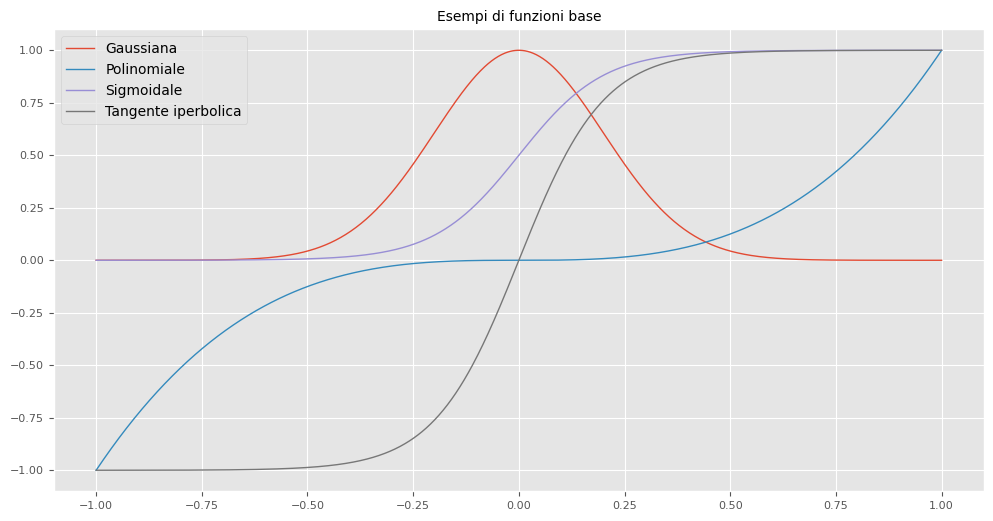

In [6]:
fig =plt.figure(figsize=(12,6))
x = np.linspace(-1,1,1000)
plt.plot(x, partial(gaussian_basis_function, **{'mu':0, 'sigma':0.2})(x), linewidth=1, label='Gaussiana')
plt.plot(x, partial(polynomial_basis_function, **{'power':3})(x), linewidth=1, label='Polinomiale')
plt.plot(x, partial(sigmoid_basis_function, **{'mu':0, 'sigma':.1})(x), linewidth=1, label='Sigmoidale')
plt.plot(x, partial(tanh_basis_function, **{'mu':0, 'sigma':.1})(x), linewidth=1, label='Tangente iperbolica')
plt.legend()
plt.title('Esempi di funzioni base')
plt.show()

### Dataset considerati

I dataset considerati negli esempi seguenti sono basati su $n$ osservazioni scalari $x_{i = 1,\ldots,n}$ raccolti in una matrice (vettore colonna) $\mathbf{X}$, di dimensione $n \times 1$. I valori target $\mathbf{t}$ sono generati da $\mathbf{X}$ per mezzo di due funzioni `f` e `g` che introducono anche del rumore casuale gaussiano con varianza predefinita e specificata dal parametro `noise_variance`. La funzione `f` sarà utilizzata per generare campioni rumorosi da una linea retta, mentre `g` genererà compioni casuali rumorosi per una sinusoide.

In [7]:
#valori parametri per la funzione f
f_w0 = -0.3
f_w1 =  0.5

def f(X, noise_variance):
    #Funzione lineare con rumore gaussiano additivo
    return f_w0+f_w1*X+noise(X.shape, noise_variance)

def g(X, noise_variance):
    #Funzione sinusoidale con rumore gaussiano additivo
    return 0.5+np.sin(2*np.pi*X)+noise(X.shape, noise_variance)

def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

In [8]:
# calcola griglia di punti per la visualizzazione della funzione f
x = np.linspace(-1, 1, 1000).reshape(-1, 1)
# calcola valori assunti da f nei punti
y1 = f(x, noise_variance=0)

# estrae un campione di n elementi nel dataset
n = 50
X = np.random.rand(n, 1)*2-1

# calcola i corrispondenti valori target applicando la funzione f e aggiungendo rumore con precision beta
beta = 250.0
t1 = f(X, noise_variance=1/beta)

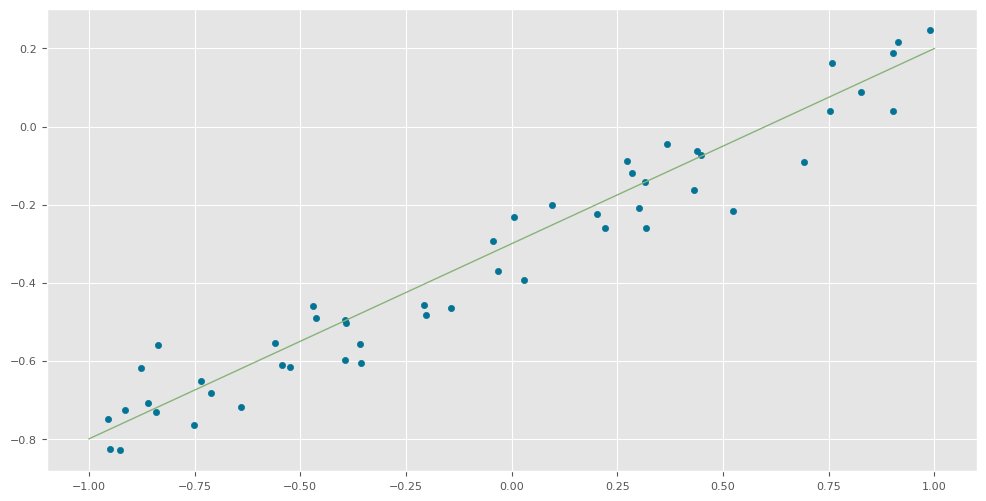

In [9]:
# plot della funzione f e del dataset
fig = plt.figure(figsize=(12,6))
plt.scatter(X, t1, s=20, color=colors[1])
plt.plot(x, y1, linewidth=1, color=colors[3])
plt.show()

In [10]:
#calcola i valori associati ai punti per mezzo della funzione g
t2 = g(X, noise_variance=1/beta)
y2 = g(x, noise_variance=0)

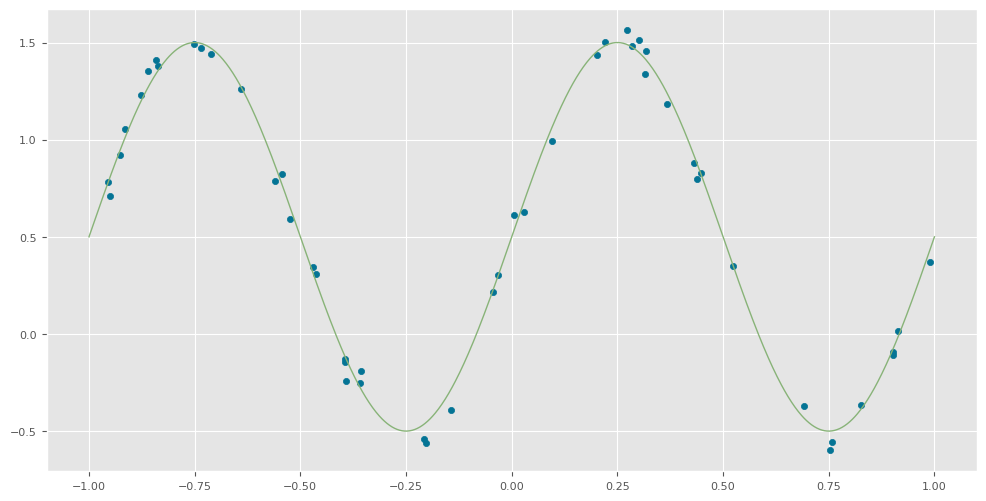

In [11]:
# plot della funzione g e del dataset
fig = plt.figure(figsize=(12,6))
plt.scatter(X, t2, s=20, color=colors[1])
plt.plot(x, y2, linewidth=1, color=colors[3])
plt.show()

### Funzioni base

Un modello lineare nell'input $x$ è sufficiente per una predizione effettuata nel primo caso, in cui la funzione `f` è una retta. In questo caso, non è necessario trasformare $x$ per mezzo di una funzione base, il che è equivalente a usare una funziona base identità. Per effettuare predizioni nel caso del dataset sinusoidale sarà conveniente trasformare l'input $x$ ad esempio per mezzo di una funzione base gaussiana o, come vedremo, con funziona base polinomiale. Queste funzioni base non lineari sono necessarie per modellare la relazione non lineare tra elementi $x$ e target corrispondente $t$. La _design matrix_ $\boldsymbol\Phi$ viene calcolata dalle osservazioni $\mathbf{X}$ per mezzo di una funzione base parametrica attraverso la funzione `expand`. Questa funzione inserisce in $\boldsymbol\Phi$ anche un vettore colonna costante $\mathbf{1}$ a rappresentare l'ipotesi $\phi_0(x) = 1$.

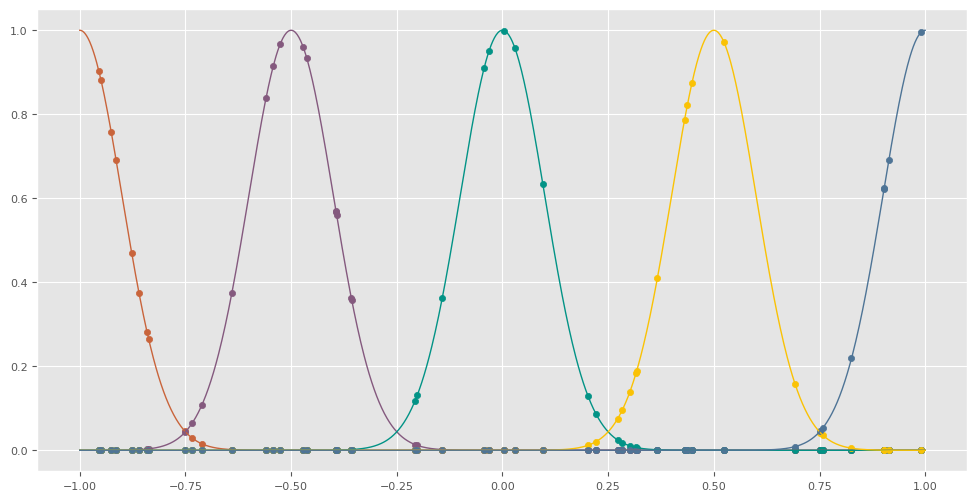

In [12]:
# funzioni base gaussiane 
# numero di funzioni base considerate
k = 5

# medie delle funzioni base, distribuite sull'intervallo considerato
mus = np.linspace(-1, 1, k)

fig = plt.figure(figsize=(12,6))
plt.scatter(X, np.zeros_like(X), s=20, color=colors[1])
for i, mu in enumerate(mus):  
    plt.plot(x, partial(gaussian_basis_function, **{'mu':mu, 'sigma':0.1})(x), linewidth=1, color=colors[4+i])
    plt.scatter(X, partial(gaussian_basis_function, **{'mu':mu, 'sigma':0.1})(X), s=20, color=colors[4+i])
plt.show()

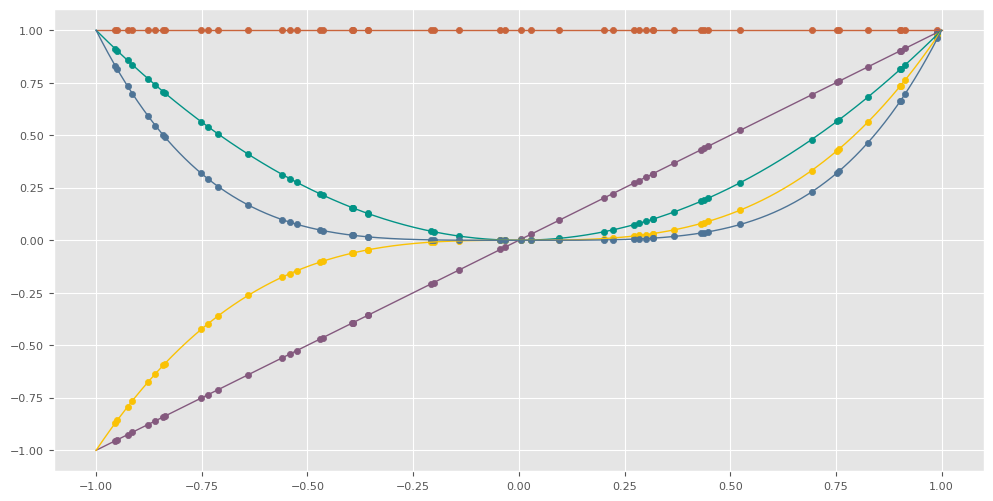

In [13]:
# funzioni base polinomiali 
k = 5

# grado delle funzioni base
powers = np.arange(k)

fig = plt.figure(figsize=(12,6))
for i, power in enumerate(powers):  
    plt.plot(x, partial(polynomial_basis_function, **{'power':power})(x), linewidth=1, color=colors[4+i])
    plt.scatter(X, partial(polynomial_basis_function, **{'power':power})(X), s=20, color=colors[4+i])
plt.show()

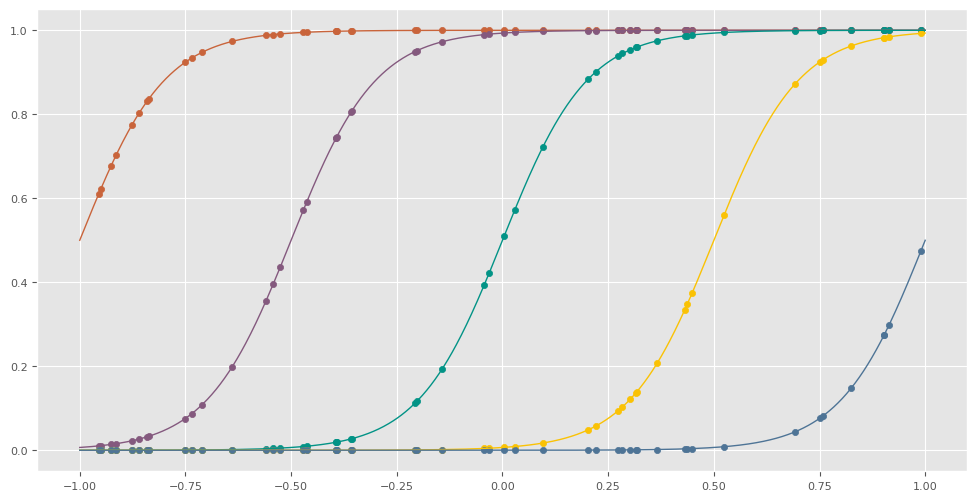

In [14]:
# funzioni base sigmoidali 
k = 5

# punti centrali delle funzioni base, distribuiti sull'intervallo considerato
mus = np.linspace(-1, 1, k)

fig = plt.figure(figsize=(12,6))
for i, mu in enumerate(mus):  
    plt.plot(x, partial(sigmoid_basis_function, **{'mu':mu, 'sigma':0.1})(x), linewidth=1, color=colors[4+i])
    plt.scatter(X, partial(sigmoid_basis_function, **{'mu':mu, 'sigma':0.1})(X), s=20, color=colors[4+i])
plt.show()

## Minimizzazione del rischio empirico

In questo approccio, viene definito un insieme $\mathcal{H}$ di possibili funzioni predittive, selezionando quella che minimizza il rischio empirico

$$
\overline{\mathcal{R}}(h; \mathbf{X},\mathbf{t})=\frac{1}{n}\sum_{i=1}^nL(h(\mathbf{x}_i),t_i)
$$

cioè,

$$
\hat{h}=\underset{h\in\mathcal{H}}{\mathrm{argmin}}\;\overline{\mathcal{R}}(h;\mathbf{X},\mathbf{t})
$$

dove $L(x_1,x_2)$ è una funzione di costo (_loss_) predefinita.

Nel caso considerato qui, si assume che:

- l'insieme delle ipotesi $\mathcal{H}$ è un insieme di funzioni lineari parametriche $\sum_{j=0}^{m-1}{w_j \phi_j(\mathbf{x})}=\mathbf{\phi}(\mathbf{x})\mathbf{w}$
- la funzione di costo è il _residuo quadratico_ $(h(\mathbf{x})-t)^2$, il che implica che la minimizzazione del rischio empirico è definita come 
  
$$
\overline{\mathcal{R}}_\mathbf{\phi}(\mathbf{w}; \mathbf{\Phi},\mathbf{t})=\frac{1}{n}\sum_{i=1}^n\left(\sum_{j=0}^{m-1}{w_j \phi_j(\mathbf{x}_i)}-t_i\right)^2=\frac{1}{n}\sum_{i=1}^n\left(\mathbf{\phi}(\mathbf{x}_i)\mathbf{w}-t_i\right)^2=
{1 \over n} \lVert \mathbf{\Phi} \mathbf{w} - \mathbf{t}\rVert^2
$$

dove la _design matrix_ $\boldsymbol\Phi$ è definita come
$$
\boldsymbol\Phi = 
\begin{pmatrix}
\phi_0(\mathbf{x}_1) &  \phi_1(\mathbf{x}_1) & \cdots & \phi_{m-1}(\mathbf{x}_1) \\ 
\phi_0(\mathbf{x}_2) &  \phi_1(\mathbf{x}_2) & \cdots & \phi_{m-1}(\mathbf{x}_2) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_0(\mathbf{x}_n) &  \phi_1(\mathbf{x}_n) & \cdots & \phi_{m-1}(\mathbf{x}_n)
\end{pmatrix}
$$

e la minimizzazione è eseguita nello spazio $\mathbb{R}^m$ dei parametri
$$
\hat{\mathbf{w}}=\underset{\mathbf{w}\in\mathbb{R}^m}{\mathrm{argmin}}\;\overline{\mathcal{R}}_\mathbf{\phi}(\mathbf{w};\mathbf{X},\mathbf{t})
$$

La funzione predittiva risultante è quindi $\hat{h}(\mathbf{x})=\boldsymbol\phi(\mathbf{x})\hat{\mathbf{w}}$.

Nelle ipotesi poste, il rischio empirico ha un solo minimo locale, che è anche globale, corrispondente al valore dei parametri
$$
\hat{\mathbf{w}}=(\boldsymbol\Phi^{T}\boldsymbol\Phi)^{-1}\boldsymbol\Phi^{T}\mathbf{t}
$$

In [15]:
# minimizzazione del rischio empirico
def erm(X, t, args):
    Phi = expand(X, **args)
    return np.linalg.inv(Phi.T@Phi)@(Phi.T)@t

In [16]:
# funzione predittiva
def predict(x, w, args):
    y = expand(x, **args)@w
    if np.isscalar(x):
        return y.item()
    else:
        return y

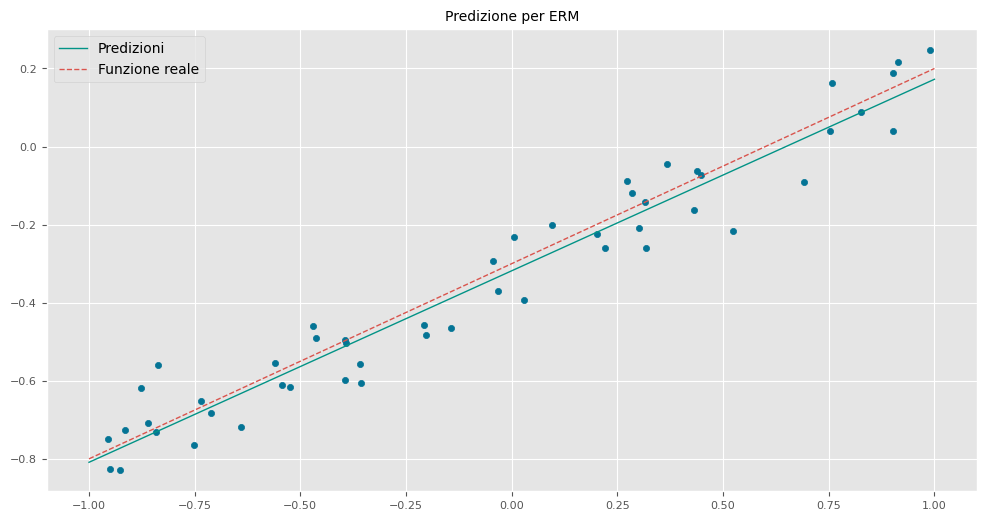

In [17]:
# caso funzione f lineare
args = {}

# calcola parametri che minimizzano il rischio empirico
w_star = erm(X, t1, args)

# visualizza funzione corretta f e valori predetti
fig = plt.figure(figsize=(12,6))
plt.scatter(X, t1, s=20, color=colors[1])
plt.plot(x, predict(x,w_star, args), linewidth=1, color=colors[6], label='Predizioni')
plt.plot(x, y1, linewidth=1, color=colors[2], linestyle='dashed', label='Funzione reale')
plt.legend()
plt.title('Predizione per ERM')
plt.show()

In [18]:
# caso funzione g sinusoidale
# numero di funzioni base
k = 10

# medie delle funzioni base gaussiane
mus = np.linspace(-1, 1, k)


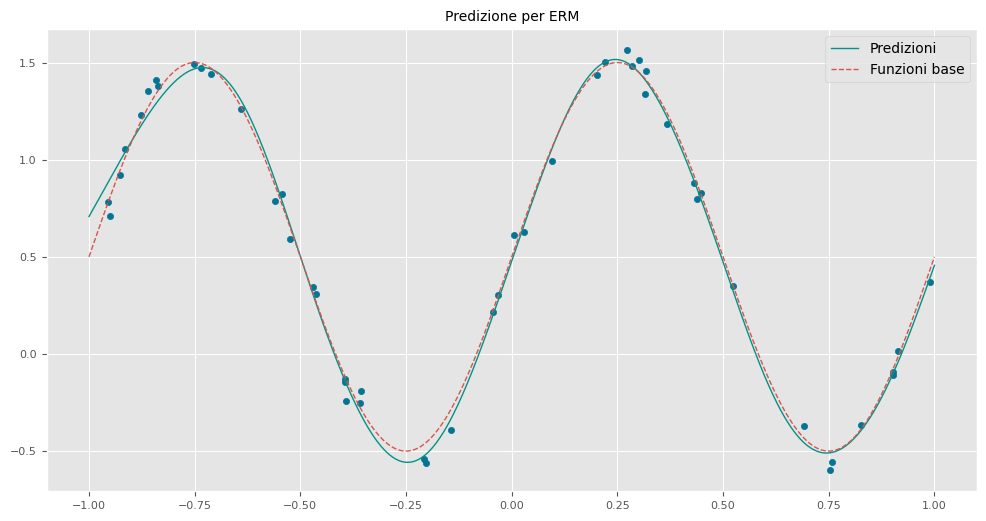

In [19]:
args = {'bf': sigmoid_basis_function, 'bf_args_list':[{'mu':mu} for mu in mus]}

# minimizza il rischio empirico dopo applicazione delle funzioni base
w_star = erm(X, t2, args)

fig = plt.figure(figsize=(12,6))
plt.scatter(X, t2, s=20, color=colors[1])
plt.plot(x, predict(x,w_star, args), linewidth=1, color=colors[6], label='Predizioni')
plt.plot(x, y2, linewidth=1, color=colors[2], linestyle='dashed', label='Funzioni base')
plt.legend()
plt.title('Predizione per ERM')
plt.show()

## Metodi probabilistici

In questo approccio viene considerata una famiglia di modelli probabilistici da cui derivare la `distribuzione congiunta' $p(\mathbf{x}, t|\mathbf{w})$. A partire da questa distribuzione, viene derivata la distribuzione condizionata $p(t|\mathbf{x}, \mathbf{X}, \mathbf{t})$ del target dato l'elemento (e il dataset),  utilizzata per le predizioni.

Dato che $p(\mathbf{x}, t|\mathbf{w})=p(t|\mathbf{x},\mathbf{w})p(\mathbf{x}|\mathbf{w})$ e dato che, inoltre, $p(\mathbf{x}|\mathbf{w})$ è in generale assunta uniforme, e quindi indipendente da $\mathbf{w}$, è possibile considerare la sola distribuzione condizionata 
$p(t|\mathbf{x},\mathbf{w})$ e il modello probabilistico parametrico può essere definito rispetto a questa distribuzione.

Una prima idea generale, qui, consiste nel calcolare un valore $\hat{\mathbf{w}}_{ML}$ che massimizza, al variare di $\mathbf{w}$, la probabilità dei dati disponibili $\mathbf{X}, \mathbf{t}$. Questa probabilità, assumendo che gli elementi siano indipendenti e uniformemente distribuiti, e che il target associato a un elemento sia indipendente da tutti gli altri elementi e dai relativi target, risulta

$$
\hat{\mathbf{w}}_{ML} = \underset{\mathbf{w}\in\mathbb{R}^m}{\mathrm{argmax}}\; p(\mathbf{X}, \mathbf{t}|\mathbf{w})=  \underset{\mathbf{w}\in\mathbb{R}^m}{\mathrm{argmax}}\; \prod_{i=1}^np(\mathbf{x}_i, t_i|\mathbf{w})=\underset{\mathbf{w}\in\mathbb{R}^m}{\mathrm{argmax}}\; \prod_{i=1}^np(t_i|\mathbf{x}_i,\mathbf{w})p(\mathbf{x}_i|\mathbf{w}) = \underset{\mathbf{w}\in\mathbb{R}^m}{\mathrm{argmax}}\; \prod_{i=1}^np(t_i|\mathbf{x}_i,\mathbf{w})
$$

La distribuzione predittiva è allora $p(t|\mathbf{x}, \mathbf{X}, \mathbf{t})=p(t|\mathbf{x}, \hat{\mathbf{w}}_{ML})$.

Si noti che, in generale, 
$$
p(t|\mathbf{x}, \mathbf{X}, \mathbf{t}) = \int p(t, \mathbf{w}|\mathbf{x}, \mathbf{X}, \mathbf{t})d\mathbf{w}= \int p(t|\mathbf{x}, \mathbf{w}, \mathbf{X}, \mathbf{t})p(\mathbf{w}|\mathbf{x}, \mathbf{X}, \mathbf{t})d\mathbf{w}= \int p(t|\mathbf{x}, \mathbf{w})p(\mathbf{w}|\mathbf{X}, \mathbf{t})d\mathbf{w}
$$
Come mostrato dal graphical model in figura, assumiamo che
$t$ sia indipendente da $\mathbf{X}$ e $\mathbf{t}$ se $\mathbf{w}$ e $\mathbf{x}$ sono dati, e che $\mathbf{w}$ sia indipendente da $\mathbf{x}$.

<img src="assets/gm_lr.png" height="200">

Selezionare un solo specifico valore di $\mathbf{w}$, come ad esempio $\hat{\mathbf{w}}$ comporta che
$$
p(t|\mathbf{x}, \mathbf{X}, \mathbf{t}) = \int p(t|\mathbf{x}, \mathbf{w})p(\mathbf{w}|\mathbf{X}, \mathbf{t})d\mathbf{w} \approx \int p(t|\mathbf{x}, \hat{\mathbf{w}})p(\mathbf{w}|\mathbf{X}, \mathbf{t})d\mathbf{w}= p(t|\mathbf{x}, \hat{\mathbf{w}}) \int p(\mathbf{w}|\mathbf{X}, \mathbf{t})d\mathbf{w} = p(t|\mathbf{x}, \hat{\mathbf{w}})
$$

Il modello probabilistico considerato qui assume che il target $t$ relativo a un elemento $\mathbf{x}$ risulti dall'applicazione di una funzione deterministica $h(\mathbf{x}, \mathbf{w})$ al cui risultato è aggiunto un rumore casuale $\epsilon$. 

$$
t = h(\mathbf{x}, \mathbf{w}) + \epsilon
$$

Facciamo l'ipotesi che il rumore sia distribuito in modo normale, e quindi secondo una gaussiana, con media nulla e precisione (inverso della varianza) predefinita $\beta$. Il modello probabilistico risultante, cioè la distribuzione condizionata di $t$ dato $\mathbf{x}$ potrà quindi essere scritta come

$$
p(t \lvert \mathbf{x}, \mathbf{w}, \beta) = 
\mathcal{N}(t \lvert h(\mathbf{x}, \mathbf{w}), \beta^{-1}) =
\sqrt{\beta \over {2 \pi}} \exp\left(-{\beta \over 2} (t - h(\mathbf{x}, \mathbf{w}))^2 \right) 
$$

La media di questa distribuzione è la `funzione di regressione` $h(\mathbf{x}, \mathbf{w})$. 

## Verosimiglianza

Considerando il caso generale in cui un insieme di funzioni base $\boldsymbol\phi(\mathbf{x})$ è applicato agli elementi, la probabilità condizionata dei target $\mathbf{t}$ dati gli elementi $\mathbf{X}$ è

$$
p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta) = 
\prod_{i=1}^{n}{\mathcal{N}(t_i \lvert \boldsymbol\phi(\mathbf{x}_i)\mathbf{w}, \beta^{-1})} 
$$

Questa è una funzione dei parametri $\mathbf{w}$ e $\beta$, denominata `verosimiglianza` (_likelihood_). Il logaritmo della verosimiglianza, o `log-verosimiglianza` (_log-likelihood_) risulta dato da 

$$
\log p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta) = 
{n \over 2} \log \beta - 
{n \over 2} \log {2 \pi} - 
\beta E_D(\mathbf{w}) 
$$

si noti che, data la monotonicità della funzione logaritmo, la verosimiglianza e la log-verosimiglianza assumono valore massimo per lo stesso valore di $\mathbf{w}$.

$E_D(\mathbf{w})$, derivante dall'esponente della distribuzione normale, è la funzione di errore corrispondente alla somma dei quadrati dei residui su tutti gli elementi del dataset.

$$
E_D(\mathbf{w}) = 
{1 \over 2} \sum_{i=1}^{n}(t_i - \boldsymbol\phi(\mathbf{x}_i)\mathbf{w})^2 = 
{1 \over 2} \lVert \mathbf{t} - \boldsymbol\Phi \mathbf{w} \rVert^2
$$

## Massima verosimiglianza

Massimizzare la log-verosimiglianza rispetto a $\mathbf{w}$ è chiaramente equivalente a minimizzare il rischio empirico definito prima. La massimizzazione della verosimiglianza può però indurre un overfitting significativo se modelli complessi (ad esempio, nel caso considerato qui, regressioni polinomiali di grado elevato) sono applicati su dataset di dimensione limitata. Un approccio diffuso per la prevenzione (o la limitazione) dell'overfitting è quello di aggiungere un termine di regolarizzazione alla funzione di costo, o alla log-verosimiglianza. Il termine di regolarizzazione viene introdotto in modo naturale come risultato dell'applicazione di metodi bayesiani (in particolare, definendo una distribuzione a priori sui parametri $\mathbf{w}$, intesi come variabili casuali). 

Inoltre, il modello permette di ottenere una stima dell'incertezza, massimizzando la verosimiglianza rispetto alla precisione $\beta$, ottenendo 

$$
\hat{\beta}^{-1}=\hat\sigma^2=\frac{1}{n}\sum_{i=1}^n\left(t_i-h(\mathbf{x}_i,\hat{\mathbf{w}})\right)^2= \frac{1}{n}\sum_{i=1}^n\left(t_i-\mathbf{\phi}(\mathbf{x})\hat{\mathbf{w}}\right)^2
$$

Nel caso specifico considerato qui, risulta

$$
\mathbf{w}^*_{ML}=\left(\Phi^T \Phi\right)^{-1} \Phi^T \mathbf{t}
$$


In [20]:
# massimizzazione della log-verosimiglianza rispetto ai parametri
def mle(X, t, args):
    Phi = expand(X, **args)
    return np.linalg.inv(Phi.T@Phi)@(Phi.T)@t

In [21]:
# massimizzazione della log-verosimiglianza rispetto alla deviazione standard
def std_ml(X, t, w, args):
    Phi = expand(X, **args)
    y = Phi@w
    return np.sqrt(np.mean((t-y)**2))

In [22]:
# funzione lineare
# calcolo dei parametri e della deviazione standard di massima verosimiglianza per il dataset considerato
args1 = {}
w_ML = mle(X, t1, args1)
std_ML = std_ml(X, t1, w_ML, args1)

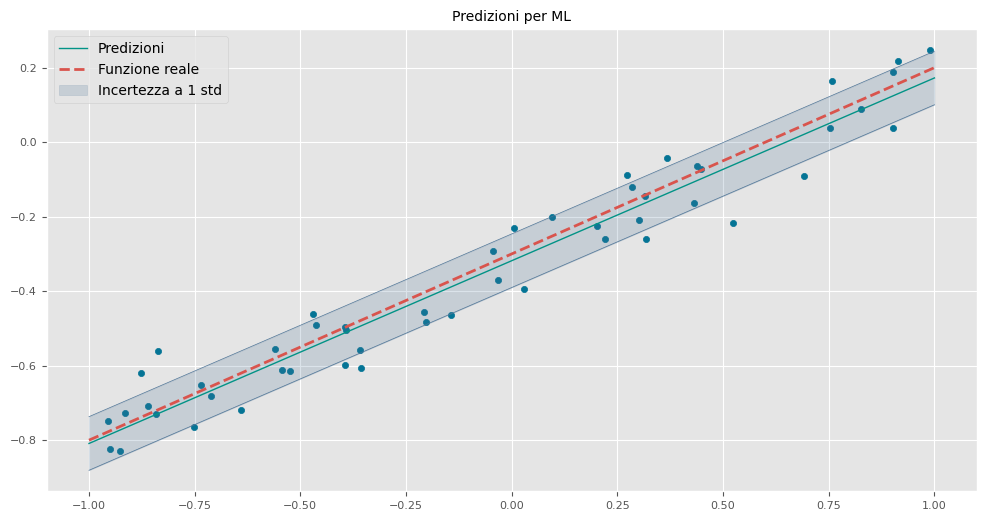

In [23]:
fig = plt.figure(figsize=(12,6))
plt.scatter(X, t1, s=20, color=colors[1])
pred = predict(x,w_ML, args1)
plt.plot(x, pred, linewidth=1, color=colors[6], label='Predizioni')
plt.plot(x, pred-std_ML, linewidth=.5, color=colors[8])
plt.plot(x, pred+std_ML, linewidth=.5, color=colors[8])
plt.plot(x, y1, linewidth=2, color=colors[2], linestyle='dashed', label='Funzione reale')
plt.fill_between(x.ravel(), (pred-std_ML).ravel(), (pred+std_ML).ravel(), color=colors[8], alpha=.2, label='Incertezza a 1 std')
plt.legend()
plt.title('Predizioni per ML')
plt.show()

In [24]:
# funzione sinusoidale
# calcolo dei parametri e della deviazione standard di massima verosimiglianza per il dataset considerato, con applicazione di funzioni base
k = 10
mus = np.linspace(-1, 1, k)
args2 = {'bf': gaussian_basis_function, 'bf_args_list':[{'mu':mu} for mu in mus]}
w_ML = mle(X, t2, args2)
std_ML = std_ml(X, t2, w_ML, args2)

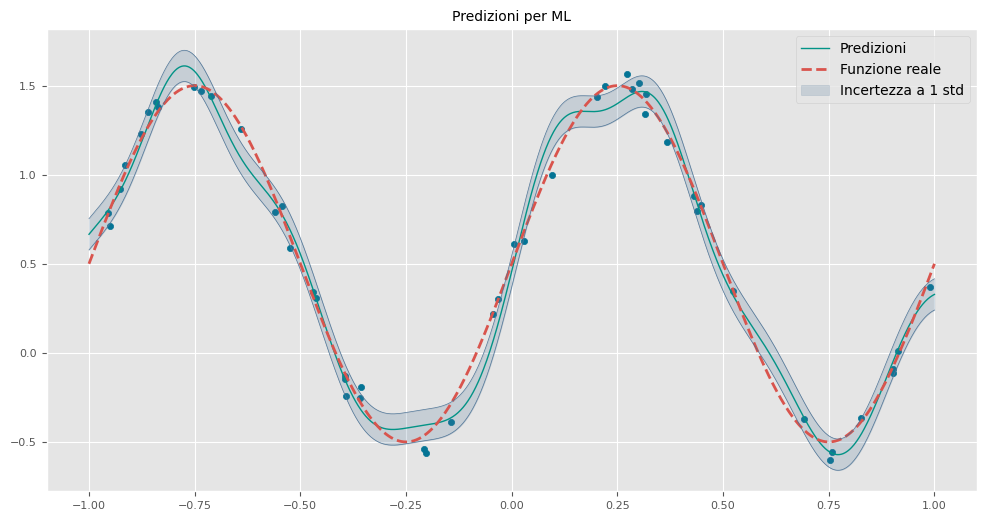

In [25]:

fig = plt.figure(figsize=(12,6))
plt.scatter(X, t2, s=20, color=colors[1])
pred = predict(x,w_ML, args2)
plt.plot(x, pred, linewidth=1, color=colors[6], label='Predizioni')
plt.plot(x, y2, linewidth=2, color=colors[2], linestyle='dashed', label='Funzione reale')
plt.plot(x, pred-std_ML, linewidth=.5, color=colors[8])
plt.plot(x, pred+std_ML, linewidth=.5, color=colors[8])
plt.fill_between(x.T.squeeze(), (pred-std_ML).ravel(), (pred+std_ML).ravel(), color=colors[8], alpha=.2, label='Incertezza a 1 std')
plt.legend()
plt.title('Predizioni per ML')
plt.show()

## Approccio Bayesiano

### Distribuzioni a priori e a posteriori

Per un trattamento bayesiano della regressione lineare è necessario introdurre una distribuzione di probabilità a priori sui parametri del modello $\mathbf{w}$. Per semplicità, si farà riferimento a una distribuzione gaussiana isotropica con media nulla:

$$
p(\mathbf{w} \lvert \alpha) = \mathcal{N}(\mathbf{w} \lvert \mathbf{0}, \alpha^{-1}\mathbf{I}) 
$$

Una gaussiana isotropica ha matrice di covarianza diagonale in cui tutti gli elementi della diagonale hanno la stessa varianza $\alpha^{-1}$ ($\alpha$ è la precisione della distribuzione a priori). Una media nulla favorisce valori a priori più piccoli dei parametri. 

In [26]:
# visualizza una gaussiana bivariata
def plot_bivariate_gaussian(mean, cov, resolution = 100):
    grid_x = grid_y = np.linspace(-1, 1, resolution)
    grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)
    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))
    plt.xticks([-1,-.5,0,.5,1])
    plt.yticks([-1,-.5,0,.5,1])
    plt.xlabel('$w_0$')
    plt.ylabel('$w_1$')

In [27]:
# calcola i parametri della distribuzione a priori
alpha = 10
cov = 1/alpha*np.eye(2, dtype=int)
mean = np.zeros(2)

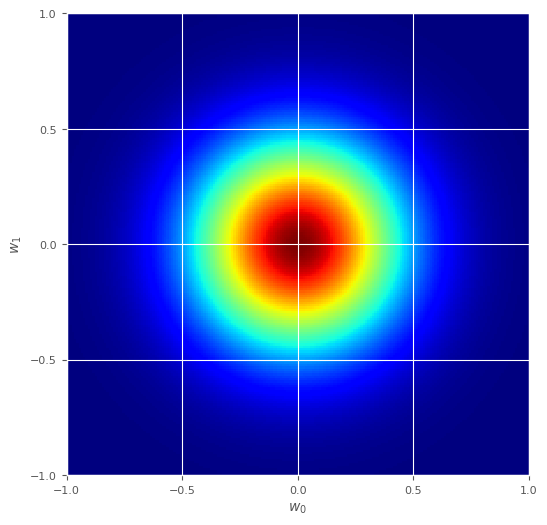

In [28]:
plt.figure(figsize=(6,6))
plot_bivariate_gaussian(mean, cov, 200)
plt.show()

La distribuzione a priori è *coniugata* alla verosimiglianza $p(\mathbf{t} \lvert \mathbf{w}, \beta)$: cioè, la distribuzione a posteriori ha la stessa forma, dal punto di vista funzionale, della distribuzione a priori, in questa caso normale. Nel contesto considerato, la distribuzione a posteriori risulta essere una gaussiana con: 

$$
p(\mathbf{w} \lvert \mathbf{X}, \mathbf{t}, \alpha, \beta) = \mathcal{N}(\mathbf{w} \lvert \mathbf{m}_p, \mathbf{\Sigma}_p) 
$$
con

\begin{align*}
\mathbf{m}_p &= \beta \mathbf{\Sigma}_p \Phi^T \mathbf{t} \\
\mathbf{\Sigma}_p &= \left(\alpha\mathbf{I} + \beta \Phi^T \Phi\right)^{-1}
\end{align*}

con
$$
\mathbf{m}_p = \beta \mathbf{\Sigma}_p \Phi^T \mathbf{t} 
$$

$$
\mathbf{\Sigma}_p = \left(\alpha\mathbf{I} + \beta \Phi^T \Phi\right)^{-1}
$$


Assumiamo per il momento che i valori di $\alpha$ e $\beta$ siano noti. Dato che la distribuzione a posteriori è proporzionale al prodotto tra verosimiglianza e distribuzione a priori, il suo logaritmo è pari (a meno di un termine additivo) alla somma della log-verosimiglianza e del logaritmo della distribuzione a priori

$$
\log p(\mathbf{w} \lvert \mathbf{X}, \mathbf{t}, \alpha, \beta) = 
-\beta E_D(\mathbf{w}) - \alpha E_W(\mathbf{w}) + \mathrm{const.} 
$$

dove, come definito sopra,

$$
E_D(\mathbf{w}) = 
{1 \over 2} \sum_{i=1}^{n}(t_i -  \boldsymbol\phi(\mathbf{x}_i)\mathbf{w})^2 = 
{1 \over 2} \lVert \mathbf{t} - \boldsymbol\Phi \mathbf{w} \rVert^2
$$

e inoltre

$$
E_W(\mathbf{w}) = {1 \over 2} \mathbf{w}^T \mathbf{w} =
{1 \over 2} \lVert \mathbf{w} \rVert^2
$$

Massimizzare il logaritmo della distribuzione a posteriori rispetto a $\mathbf{w}$ fornisce la stima _maximum-a-posteriori_ (MAP) di $\mathbf{w}$. Questo equivale a minimizzare la funzione loss data dalla somma tra $E_D$ e un termine di regolarizzazione quadratico $E_W$. Questa particolare forma di regolarizzazione è nota come _regolarizzazione L2_ o *weight decay*, in quanto tende a limitare il valore in modulo dei parametri $w_j$. Il contributo del termine di regolarizzazione è determinato dal rapporto $\alpha / \beta$.

Nel caso specifico considerato qui, dato che la distribuzione a posteriori risulta gaussiana la sua moda coincide con la media, per cui

$$
\mathbf{w}^*_{MAP}=\mathbf{m}_p=\beta \left(\alpha\mathbf{I} + \beta \Phi^T \Phi\right)^{-1} \Phi^T \mathbf{t}
$$

### Distribuzione predittiva

La predizione del target $t$ relativo a un elemento $\mathbf{x}$ viene effettuata per mezzo della distribuzione predittiva, definita come

$$
p(t \lvert \mathbf{x}, \mathbf{X}, \mathbf{t}, \alpha, \beta) = 
\int{p(t \lvert \mathbf{x}, \mathbf{w}, \beta) p(\mathbf{w} \lvert \mathbf{X}, \mathbf{t}, \alpha, \beta) d\mathbf{w}} 
$$

La distribuzione predittiva tiene conto dell'incertezza sui valori dei parametri $\mathbf{w}$ pesando la distribuzione condizionale $p(t \lvert \mathbf{x}, \mathbf{w}, \beta)$ calcolata per ogni valore dei parametri con la probabilità del valore dei parametri calcolata per mezzo della distribuzione a posteriori $p(\mathbf{w} \lvert \mathbf{X}, \mathbf{t}, \alpha, \beta)$ e sommando sull'intero spazio dei parametri. Usando la distribuzione predittiva è possibile ottenere per ogni elemento $\mathbf{x}$ il valore atteso del target associato $t$, e inoltre una stima dell'incertezza di tale predizione. Nel caso considerato, la distribuzione a posteriori risulta anch'essa gaussiana

$$
p(t \lvert \mathbf{x}, \mathbf{X}, \mathbf{t}, \alpha, \beta) = 
\mathcal{N}(t \lvert \boldsymbol\phi(\mathbf{x})\mathbf{m}_p , \sigma_n^2(\mathbf{x}))
$$

dove il valore atteso $\boldsymbol\phi(\mathbf{x})\mathbf{m}_p $ è la stima del valore della funzione di regressione e $\sigma_n^2(\mathbf{x})$ è la corrispondente varianza predittiva

$$
\sigma_n^2(\mathbf{x}) = {1 \over \beta} + \boldsymbol\phi(\mathbf{x}) \mathbf{\Sigma}_p \boldsymbol\phi(\mathbf{x})^T
$$

Il primo termine dell'espressione precedente rappresenta il rumore intrinseco nei dati, mentre il secondo è relativo all'incertezza sui valori dei parametri $\mathbf{w}$. Fino ad ora, abbiamo assunto che i valori di $\alpha$ e $\beta$ siano noti. 


In [29]:
# massimizzazione della distribuzione a posteriori rispetto ai parametri
def mpe(X, t, alpha, beta, args):
    Phi = expand(X, **args)
    Sigma_p_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T@Phi
    Sigma_p = np.linalg.inv(Sigma_p_inv)
    m_p = beta * Sigma_p@(Phi.T)@t
    return m_p, Sigma_p

In [30]:
def posterior_predictive(X, m_p, Sigma_p, beta, args):
    Phi = expand(X, **args)
    y = Phi@m_p
    y_var = 1 / beta + np.diag(Phi@Sigma_p@Phi.T).reshape(-1,1)
    return y, y_var

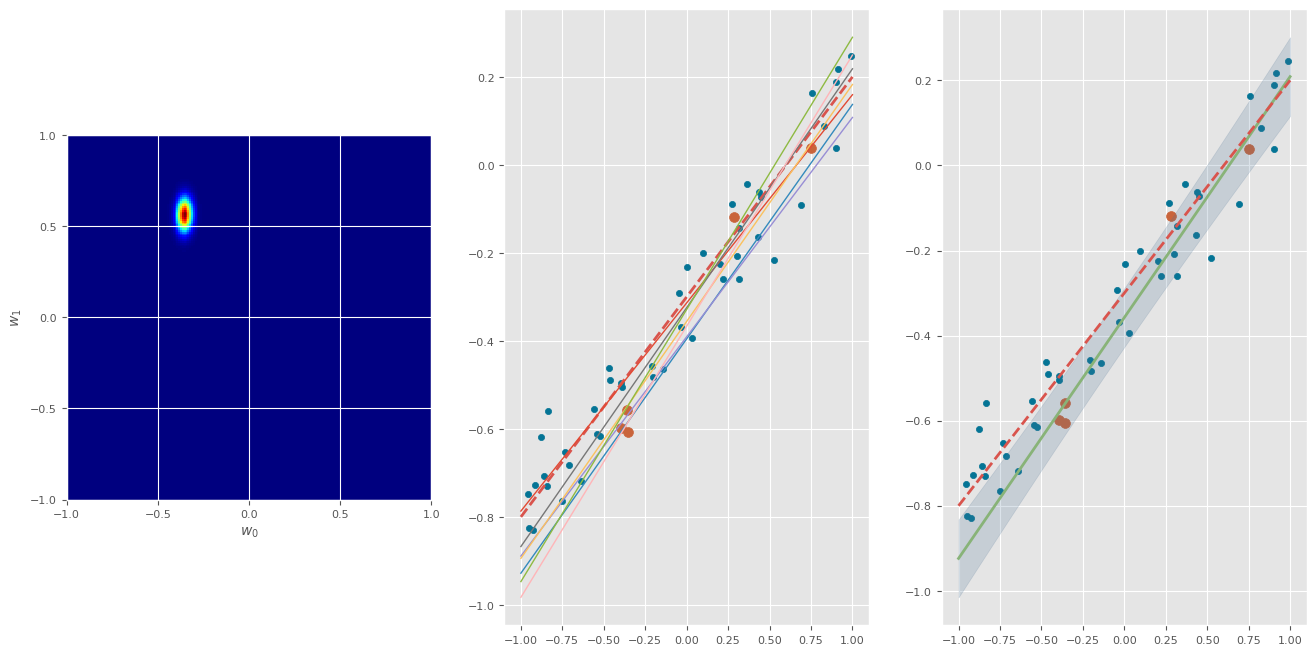

In [31]:
# funzione lineare
# numero di esempi considerati per il calcolo della distribuzione a posteriori
nexamples = 5
# numero di modelli campionati dalla distribuzione a posteriori
nsamples = 7
# determina l'insieme di esempi considerati
idx = random.sample(range(X.shape[0]), nexamples)
X_s, t_s = X[idx], t1[idx]
# applica funzioni base (identità in questo caso)
args1 = {}
# calcola distribuzione a posteriori dei parametri
m_p, Sigma_p = mpe(X_s, t_s, alpha, beta, args1)
# estrae insieme di modelli predittivi
w_samples = np.random.multivariate_normal(m_p.ravel(), Sigma_p, nsamples)
# calcola predizioni per tutti i punti della griglia
pred, sigma_2 = posterior_predictive(x, m_p, Sigma_p, beta, args1)

fig = plt.figure(figsize=(16,8))
# plot della distribuzione a posteriori (bivariata)
plt.subplot(1,3,1)
plot_bivariate_gaussian(m_p, Sigma_p, 200)
plt.subplot(1,3,2)
# punti nel dataset
plt.scatter(X, t1, s=20, color=colors[1])
# punti effettivamente considerati 
plt.scatter(X_s, t_s, s=50, color=colors[4])
# funzione reale
plt.plot(x, y1.ravel(), linestyle='dashed', linewidth=2, color=colors[2])
# funzioni predittive da sampling della distribuzione a posteriori
for w in w_samples:
    plt.plot(x, np.dot(expand(x, **args1), w.reshape(-1,1)), linewidth=1)
plt.subplot(1,3,3)
plt.plot(x,pred, color=colors[3], label='predizione',linewidth=2)
plt.scatter(X, t1, s=20, color=colors[1])
plt.scatter(X_s, t_s, s=50, color=colors[4])
# plot distribuzione predittiva
plt.plot(x, y1, linestyle='dashed', linewidth=2, color=colors[2])
plt.fill_between(x.ravel(), pred.ravel()-np.sqrt(sigma_2.ravel()), pred.ravel()+np.sqrt(sigma_2.ravel()), color=colors[8], alpha=.2)
plt.show()

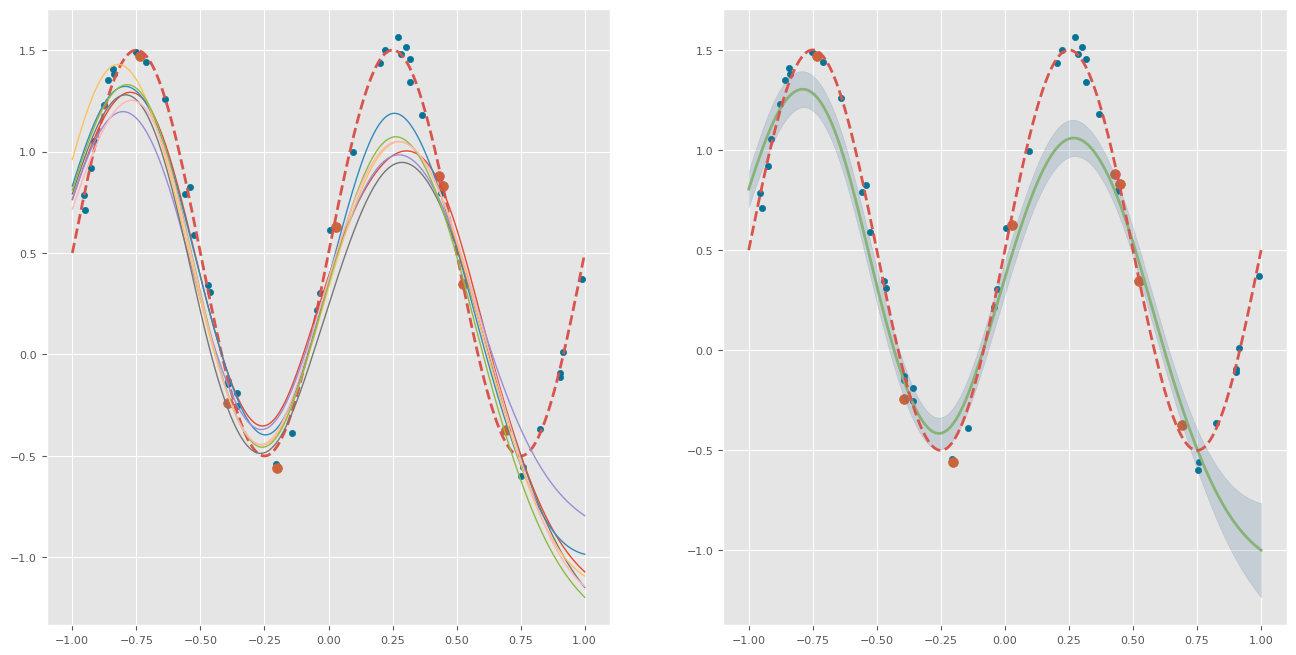

In [33]:
# funzione sinusoidale
# numero di esempi considerati per il calcolo della distribuzione a posteriori
nexamples = 8
# numero di modelli campionati dalla distribuzione a posteriori
nsamples = 7
# determina l'insieme di esempi considerati
# determina l'insieme di esempi considerati
idx = random.sample(range(X.shape[0]), nexamples)
X_s, t_s = X[idx], t2[idx]
# applica funzioni base (sigmoidali in questo caso)
k = 10
mus = np.linspace(-1, 1, k)
args2 = {'bf': sigmoid_basis_function, 'bf_args_list':[{'mu':mu} for mu in mus]}

# calcola distribuzione a posteriori dei parametri
m_p, Sigma_p = mpe(X_s, t_s, alpha, beta, args2)
# estrae insieme di modelli predittivi
w_samples = np.random.multivariate_normal(m_p.ravel(), Sigma_p, nsamples)
# calcola predizioni per tutti i punti della griglia
pred, sigma_2 = posterior_predictive(x, m_p, Sigma_p, beta, args2)

fig = plt.figure(figsize=(16,8))
# plot della distribuzione a posteriori (bivariata)
plt.subplot(1,2,1)
# punti nel dataset
plt.scatter(X, t2, s=20, color=colors[1])
# punti effettivamente considerati 
plt.scatter(X_s, t_s, s=50, color=colors[4])
# funzione reale
plt.plot(x, y2.ravel(), linestyle='dashed', linewidth=2, color=colors[2])
# funzioni predittive da sampling della distribuzione a posteriori
for w in w_samples:
    plt.plot(x, np.dot(expand(x, **args2), w.reshape(-1,1)), linewidth=1)
plt.subplot(1,2,2)
plt.plot(x,pred, color=colors[3], label='predizione',linewidth=2)
plt.scatter(X, t2, s=20, color=colors[1])
plt.scatter(X_s, t_s, s=50, color=colors[4])
# plot distribuzione predittiva
plt.plot(x, y2, linestyle='dashed', linewidth=2, color=colors[2])
plt.fill_between(x.ravel(), pred.ravel()-np.sqrt(sigma_2.ravel()), pred.ravel()+np.sqrt(sigma_2.ravel()), color=colors[8], alpha=.2)
plt.show()

Al crescere del numero di esempi considerati, la varianza - e quindi l'incertezza - delle predizioni diminuisce. Inoltre, regioni con meno osservazioni presentano una maggiore incertezza.

### Verosimiglianza marginale e evidenza

In un approccio completamente bayesiano, comunque, sarebbe necessario definire distribuzioni a priori anche per gli iperparametri $\alpha$ e $\beta$, utilizzando le corrispondenti distribuzioni a posteriori per tener conto nelle predizioni dell'incertezza rispetto ai loro valori. 

$$
p(t \lvert \mathbf{x}, \mathbf{X}, \mathbf{t}, \alpha, \beta) = 
\int{p(t \lvert \mathbf{x}, \mathbf{w}, \beta) p(\mathbf{w} \lvert \mathbf{X}, \mathbf{t}, \alpha, \beta) p(\alpha) p(\beta)d\mathbf{w}}\;d\alpha\;d\beta
$$

Purtroppo, l'integrazione completa di tutti e tre i parametri (e iperparametri) $\mathbf{w}$, $\alpha$ e $\beta$ rende il modello intrattabile dal punto di vista analitico, e costringendo all'utilizzo di soluzioni alternative, ottenute per mezzo di metodi approssimati. 

Delle stime di $\alpha$ e $\beta$ possono essere alternativamente ottenute mediante massimizzazione della `verosimiglianza marginale` (_marginal likelihood_), ottenute mediante integrazione dei parametri $\mathbf{w}$ dalla verosimiglianza.

$$
p(\mathbf{X}, \mathbf{t} \lvert \alpha, \beta) =
\int{p(\mathbf{X}, \mathbf{t} \lvert \mathbf{w}, \beta) p(\mathbf{w} \lvert \alpha) d\mathbf{w}} 
$$

Dato che $p(\alpha, \beta|\mathbf{X}, \mathbf{t})\propto p(\mathbf{X}, \mathbf{t} \lvert \alpha, \beta) p(\alpha, \beta)$, se assumiamo che la distribuzione a priori degli iperparametri $p(\alpha,\beta)$ sia uniforme, allora possiamo confrontare le probabilità della coppia $\alpha, \beta$ dato il dataset $\mathbf{X}, \mathbf{t}$ confrontando le rispettive verosimiglianze marginali

$$
\frac{p(\alpha_1, \beta_1|\mathbf{X}, \mathbf{t})}{p(\alpha_2, \beta_2|\mathbf{X}, \mathbf{t})}=\frac{p(\mathbf{X}, \mathbf{t}|\alpha_1, \beta_1)}{p(\mathbf{X}, \mathbf{t}|\alpha_2, \beta_2)}
$$
questo rapporto è denominato _Bayes factor_.

Inoltre, dato che $p(\mathbf{X}, \mathbf{t} \lvert \alpha, \beta)=p(\mathbf{t} \lvert \mathbf{X}, \alpha, \beta)p(\mathbf{t} \lvert \mathbf{X}, \alpha, \beta)$, se facciamo l'ipotesi comune che $\mathbf{X}$ sia indipendente dal modello e dai suoi parametri e iperparametri, otteniamo 

$$
p(\mathbf{X}, \mathbf{t} \lvert \alpha, \beta)\propto p(\mathbf{t} \lvert \mathbf{X}, \alpha, \beta)
$$ 

dove il secondo termine è la probabilità del target dati gli elementi, ottenuta integrando i parametri $\mathbf{w}$ dalla verosimiglianza

$$
p(\mathbf{t} \lvert \mathbf{X}, \alpha, \beta) =
\int{p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta) p(\mathbf{w} \lvert \alpha) d\mathbf{w}} 
$$

La distribuzione $p(\mathbf{t} \lvert \mathbf{X}, \alpha, \beta)$ compare anche a denominatore (svolgendo il ruolo dell'_evidenza-) nella relazione, derivante dalla regola di Bayes

$$
p(\mathbf{w} \lvert \mathbf{X}, \mathbf{t}, \alpha, \beta) = 
{p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta) p(\mathbf{w} \lvert \alpha) \over p(\mathbf{t} \lvert \mathbf{X}, \alpha, \beta)}  
$$

In questa situazione, possiamo confrontare le coppie di probabilità $\alpha, \beta$, dato il dataset $\mathbf{X}, \mathbf{t}$ confrontando le corrispondenti evidenze

$$
\frac{p(\alpha_1, \beta_1|\mathbf{X}, \mathbf{t})}{p(\alpha_2, \beta_2|\mathbf{X}, \mathbf{t})}=\frac{p(\mathbf{t}|\mathbf{X}, \alpha_1, \beta_1)}{p(\mathbf{t}|\mathbf{X}, \alpha_2, \beta_2)}
$$

L'eliminazione della presenza esplicita dei parametri mediante la loro integrazione rende direttamente comparabili modelli di diversa complessità, confrontando le loro evidenze sui dati del training set senza far ricorso a validation set.


Nel contesto dei modelli gaussiani per distribuzione a priori e verosimiglianza considerati qui, il logaritmo dell'evidenza è dato da

$$
\log p(\mathbf{t} \lvert \mathbf{X}, \alpha, \beta) = \frac{m}{2}\log\alpha + \frac{n}{2}\log\beta -
E(\mathbf{m}_p)-\frac{1}{2}\log\lvert\mathbf{\Sigma}_p^{-1}\rvert - \frac{n}{2}\log\frac{2}{\pi} \tag{18}
$$

dove

$$
E(\mathbf{m}_p) = \frac{\beta}{2} \lVert \mathbf{t} - \boldsymbol\Phi \mathbf{m}_p \rVert^2 +
\frac{\alpha}{2} \lVert\mathbf{m}_p\rVert^2
$$


In [34]:
# calcola la verosimiglianza marginale
def log_marginal_likelihood(X, t, alpha, beta, args):
    Phi = expand(X, **args)
    n, m = Phi.shape
    m_p, Sigma_p = mpe(X, t, alpha, beta, args)
    Sigma_p_inv = np.linalg.inv(Sigma_p)
    E_D = beta * np.sum((t - Phi@m_p) ** 2)
    E_W = alpha * np.sum(m_p ** 2)
    score = m*np.log(alpha) + n*np.log(beta) - E_D - E_W - np.log(np.linalg.det(Sigma_p_inv)) - n*np.log(2*np.pi)
    return 0.5 * score

#### Massimizzazione della verosimiglianza marginale

L'approccio di stimare i valori degli iperparametri $\alpha$ e $\beta$ massimizzando rispetto ad essi la verosimiglianza marginale (o l'evidenza) prende il nome di  _empirical Bayes_. E' possibile mostrare che il valore ottenuto è una buona approssimazione per un approccio completamente bayesiano se la distribuzione a posteriori di $\alpha$ e $\beta$ è fortemente concentrata intorno alla moda, mentre la distribuzione a priori è quasi uniforme. 

Integrare i parametri del modello, o anche usare una buona approssimazione per essi, ci permette di stimare i migliori valori di $\alpha$ e $\beta$, e quindi della fattore di regolarizzazione $\alpha / \beta$, direttamente dai soli dati di training, senza introdurre e utilizzare un validation set.

Cardinalità diverse dell'insieme delle funzioni di base gaussiane equidistanti sono confrontate sulla base della log-verosimiglianza marginale calcolata su un dataset di esempi. Assumiamo ancora che i valori di $\alpha$ e $\beta$ siano fissati.

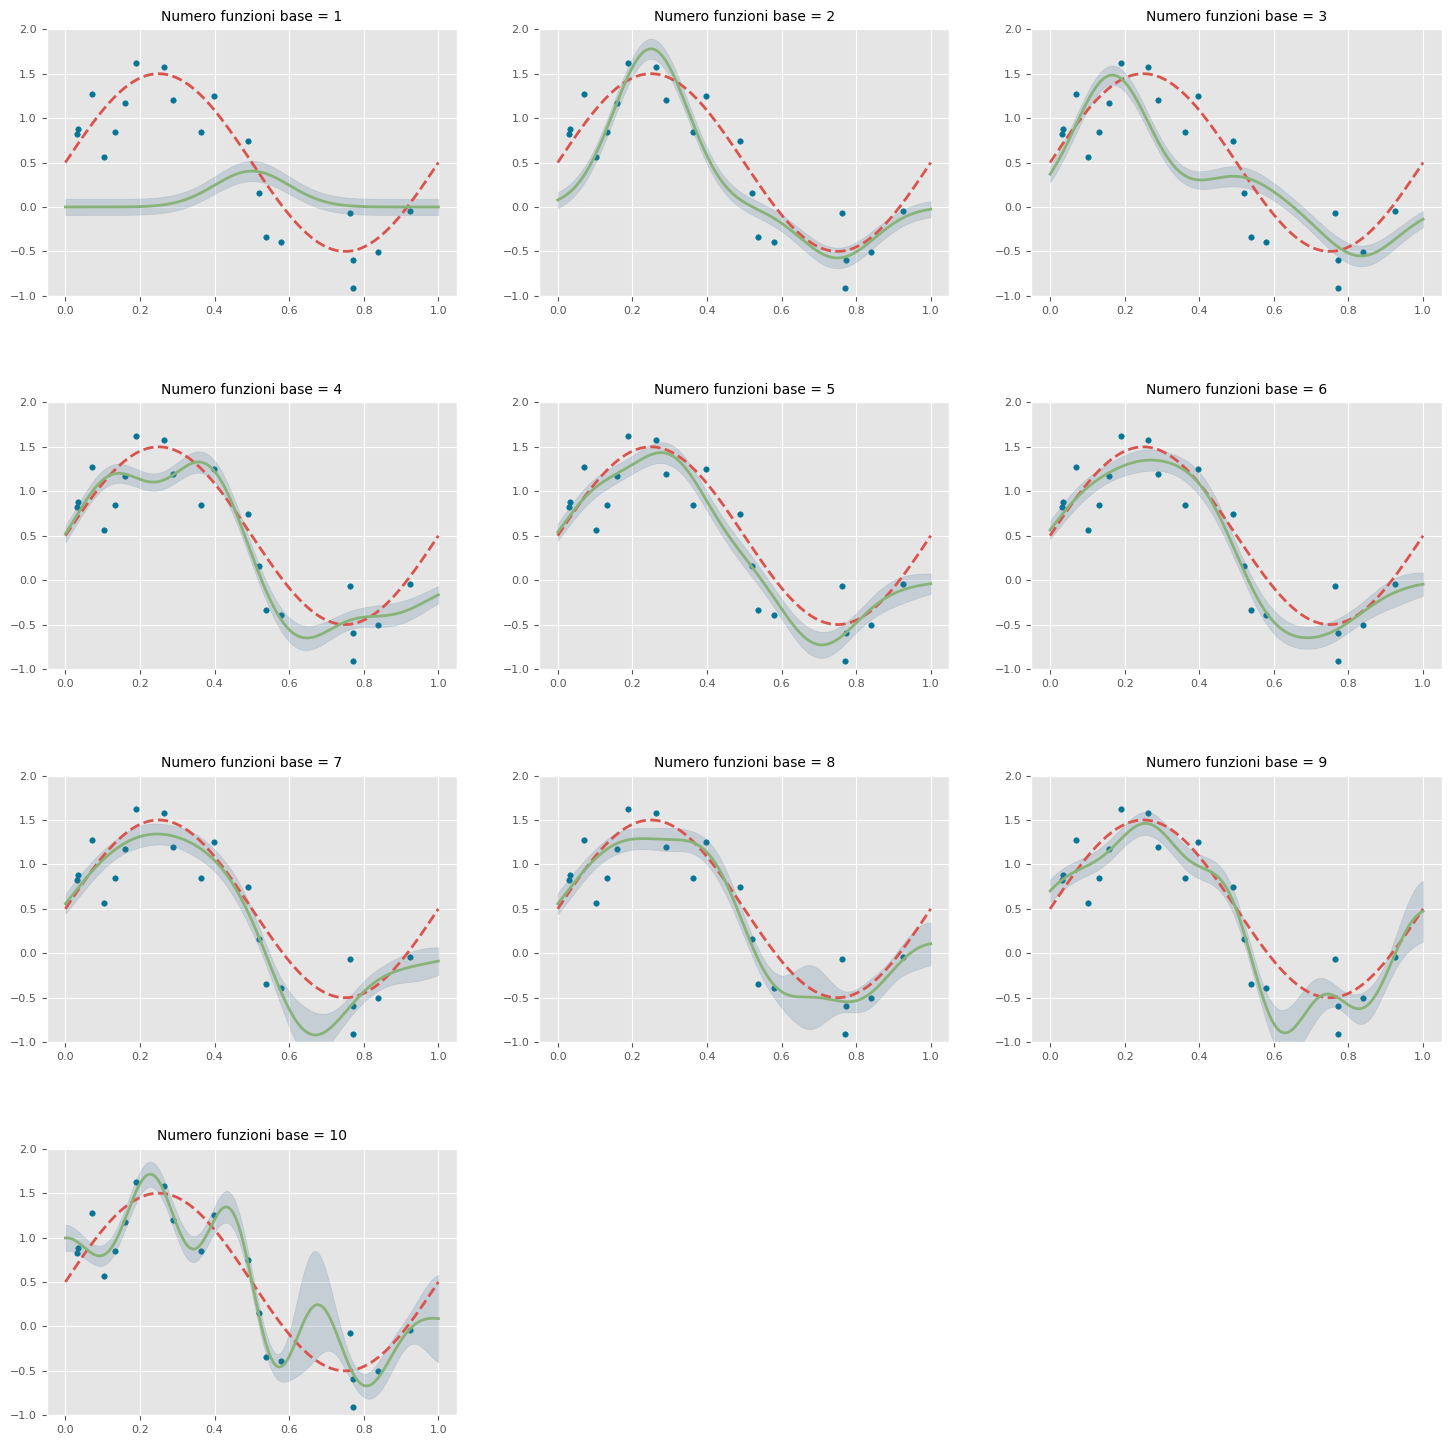

In [36]:
beta = 1/(0.3 ** 2)
alpha = 0.005

nexamples = 20

x0 = np.linspace(0, 1, 1000).reshape(-1, 1)
y0 = g(x0, noise_variance=0).T

X_ = np.random.rand(50, 1)
X0 = X_[:nexamples]
t0 = g(X0, noise_variance=1/beta)

degree = 9
degrees = range(degree + 1)

m = 10
rows = int(m/3)+1

plt.figure(figsize=(18, 18))
plt.subplots_adjust(hspace=0.4)
for d in range(1, m+1):
    mus = np.linspace(x0[0], x0[-1], d+1)
    args0 = {'bf': gaussian_basis_function, 'bf_args_list':[{'mu':mus[k]+.5*(mus[k+1]-mus[k])} for k in range(len(mus)-1)]}
    m_p, Sigma_p = mpe(X0, t0, alpha, beta, args0)
    y, y_var = posterior_predictive(x0, m_p, Sigma_p, beta, args0)
    plt.subplot(rows, 3, d)
    plt.scatter(X0,t0, s=15, color=colors[1])
    plt.plot(x0,y0.ravel(), color=colors[2], linestyle='dashed')
    plt.plot(x0, y, color=colors[3])
    plt.fill_between(x0.ravel(),y.ravel()-y_var.ravel(),y.ravel()+y_var.ravel(), color=colors[8], alpha=.2)
    plt.title(f'Numero funzioni base = {d}')
    plt.ylim(-1.0, 2.0)

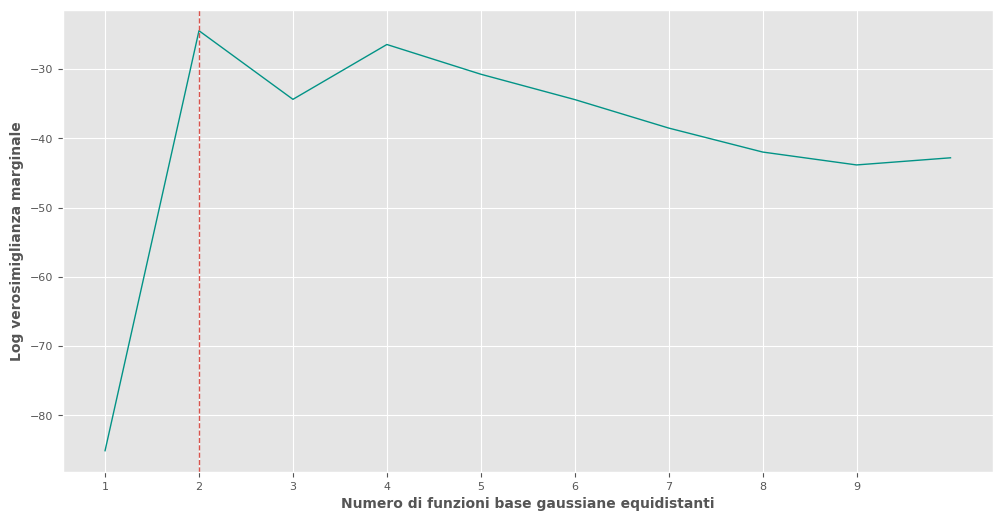

In [62]:
mlls = []

for d in range(1, m+1):
    mus = np.linspace(x0[0], x0[-1], d+1)
    args0 = {'bf': gaussian_basis_function, 'bf_args_list':[{'mu':mus[k]+.5*(mus[k+1]-mus[k])} for k in range(len(mus)-1)]}
    mll = log_marginal_likelihood(X0, t0, alpha, beta, args0)
    mlls.append(mll)

degree_max = np.argmax(mlls)+1
fig = plt.figure(figsize=(12,6))
plt.plot(range(1,m+1), mlls, color=colors[6], linewidth=1)
plt.axvline(x=degree_max, linestyle='dashed', color=colors[2], lw=1)
plt.xticks(range(1, m))
plt.xlabel('Numero di funzioni base gaussiane equidistanti')
plt.ylabel('Log verosimiglianza marginale');

Nel contesto considerato  qui, la massimizzazione del logaritmo dell'evidenza (e della log-verosimiglianza marginale) rispetto a $\alpha$ e $\beta$ fornisce le seguenti soluzioni implicite

\begin{align*}
\alpha & = \frac{\gamma}{\mathbf{m}_n^T \mathbf{m}_n} \\
\frac{1}{\beta} & = \frac{1}{n-\gamma} \sum_{i=1}^{n}(t_i - \mathbf{m}_n^T \boldsymbol\phi(\mathbf{x}_i))^2 
\end{align*}

con 

$$
\gamma = \sum_{i=0}^{m-1} \frac{\lambda_i}{\alpha+\lambda_i} 
$$


I valori $\lambda_i$ sono gli autovalori della matrice $\beta \boldsymbol\Phi^T \boldsymbol\Phi$. Le soluzioni sono implicite in quanto sia  $\alpha$ che $\beta$ dipendono da $\gamma$ e $\gamma$ dipende sia da $\alpha$ che da $\beta$. Soluzioni per $\alpha$ e $\beta$ possono essere ottenute a partire da valori iniziali arbitrari per questi parametri, iterando poi le relazioni precedenti fino a convergenza.

In [39]:
def marginal_likelihood_maximization(X, t, args, alpha=1e-5, beta=1e-5, max_iter=200, rtol=1e-5, verbose=False):
    Phi = expand(X, **args)
    eigenvalues_0 = np.linalg.eigvalsh(Phi.T.dot(Phi))
    for i in range(max_iter):
        beta_prev = beta
        alpha_prev = alpha
        eigenvalues = eigenvalues_0*beta
        m_p, _ = mpe(X, t, alpha, beta, args)
        gamma = np.sum(eigenvalues/(eigenvalues + alpha))
        alpha = gamma/np.sum(m_p**2)
        beta_inv = 1/(Phi.shape[0]-gamma)*np.sum((t-Phi.dot(m_p))**2)
        beta =1/beta_inv
        if np.isclose(alpha_prev, alpha, rtol=rtol) and np.isclose(beta_prev, beta, rtol=rtol):
            if verbose:
                print(f'Convergenza dopo {i + 1} iterazioni.')
            return alpha, beta
    if verbose:
        print(f'Computazione fermata dopo {max_iter} iterazioni.')
    return alpha, beta

In [40]:
N = 30

degree = 4

Xc = np.linspace(0, 1, N).reshape(-1, 1)
tc = g(Xc, noise_variance=0.3 ** 2)

args = {'bf': polynomial_basis_function, 'bf_args_list':[{'power':k} for k in range(1, degree + 1)]}

alpha, beta, = marginal_likelihood_maximization(Xc, tc, args, rtol=1e-5, verbose=True)
print('alpha* = {}'.format(alpha))
print('beta* = {}'.format(beta))

Convergenza dopo 32 iterazioni.
alpha* = 0.000604627328627508
beta* = 10.580636775633948


Alternativamente, possiamo usare _BayesianRidge_ di scikit-learn. I metodi `fit` e `predict` di quella classe corrispondono alle funzioni `mpe` e `posterior_predictive` definite sopra. L'implementazione di `BayesianRidge` è molto simile a quella introdotta sopra, eccetto il fatto che vengono utilizzate distribuzioni _Gamma_ come distribuzioni a priori degli iperparametri $\alpha$ e $\beta$. Di conseguenza, la probabilità a priori di tali parametri tende ad essere più elevata per valori piccoli. Nell'implementazione precedente, si procede semplicemente ad iniziare l'ottimizzazione da valori piccoli di $\alpha$ e $\beta$.

In [41]:
from sklearn.linear_model import BayesianRidge
Phi = expand(Xc, **args)
br = BayesianRidge(fit_intercept=False, tol=1e-5, verbose=True)
br.fit(Phi, tc.ravel())
print('alpha* = {}'.format(br.lambda_))
print('beta* = {}'.format(br.alpha_))

Convergence after  31  iterations
alpha* = 0.0006046207587834792
beta* = 10.580646385639614


When comparing the results from our implementation with those from `BayesianRidge` we see that they are almost identical. In the following, inferred values for $\alpha$, $\beta$ and $\mathbf{m}_N$ are compared as well as predictions and their uncertainties. Results prefixed with `np` are those from our implementation, results prefixed with `br` are those obtained with `BayesianRidge`.

In [42]:
X_test = np.random.rand(10)

In [43]:
y_np_mean, y_np_var = posterior_predictive(X_test, m_p, Sigma_p, beta, args0)

print('Prediction mean: {}'.format(y_np_mean.ravel()))
print('Prediction std: {}'.format(np.sqrt(y_np_var)))

Prediction mean: [-0.42405728  1.23572454 -0.44413162 -0.55283939  1.04192281  1.71204114
  1.67767419  1.24272632 -0.16777703  0.2386512 ]
Prediction std: [[0.45106476]
 [0.37119682]
 [0.36277146]
 [0.42913913]
 [0.37385623]
 [0.38276366]
 [0.37929576]
 [0.37090917]
 [0.40242339]
 [0.74895511]]


Observe now that the expectation of the predictive distribution 
$$
\mathbf{\phi}(\mathbf{x})\mathbf{m}_p=\mathbf{\phi}(\mathbf{x})\beta\mathbf{\Sigma}_p\mathbf{\Phi}^{T}\mathbf{t}
$$

can be written also as
$$
\mathbf{\phi}(\mathbf{x})\mathbf{m}_p=\beta\mathbf{\phi}(\mathbf{x})\mathbf{\Sigma}_p\mathbf{\Phi}^{T}\mathbf{t}=\sum_{i=1}^{n}\beta\mathbf{\phi}(\mathbf{x})\mathbf{\Sigma}_p\mathbf{\phi}(\mathbf{x}_{i})^Tt_{i}
$$

If we assume that the prediction $y(\mathbf{x})$ for $\mathbf{x}$ corresponds to this expectation, then it can be seen as a linear combination $\sum_{i=1}^nw_it_i$ of the target values $t_i$ of the items in the training set, with weights $w_i=\beta\mathbf{\phi}(\mathbf{x})\mathbf{\Sigma}_p\mathbf{\phi}(\mathbf{x}_{i})^T$ dependent from the item values $\mathbf{x}_i$ (and from $\mathbf{x}$).

The weight function 
$$
\kappa(\mathbf{x},\mathbf{x}')=\beta\mathbf{\phi}(\mathbf{x})\mathbf{\Sigma}_p\mathbf{\phi}(\mathbf{x}')^T
$$
is said *equivalent kernel*

In [44]:
def equiv_kernel(x1, x2, X, t, alpha, beta, args):
    phi_1 = expand(x1, **args)
    phi_2 = expand(x2, **args)
    _, Sigma_p = mpe(X, t, alpha, beta, args)
    return beta*phi_1@Sigma_p@(phi_2.T)

In [45]:
def predict_equiv_kernel(X_test, X, t, alpha, beta, args):
    phi_1 = expand(X_test, **args)
    phi_2 = expand(X, **args)
    _, Sigma_p = mpe(X, t, alpha, beta, args)
    return beta*phi_1@Sigma_p@(phi_2.T)@t

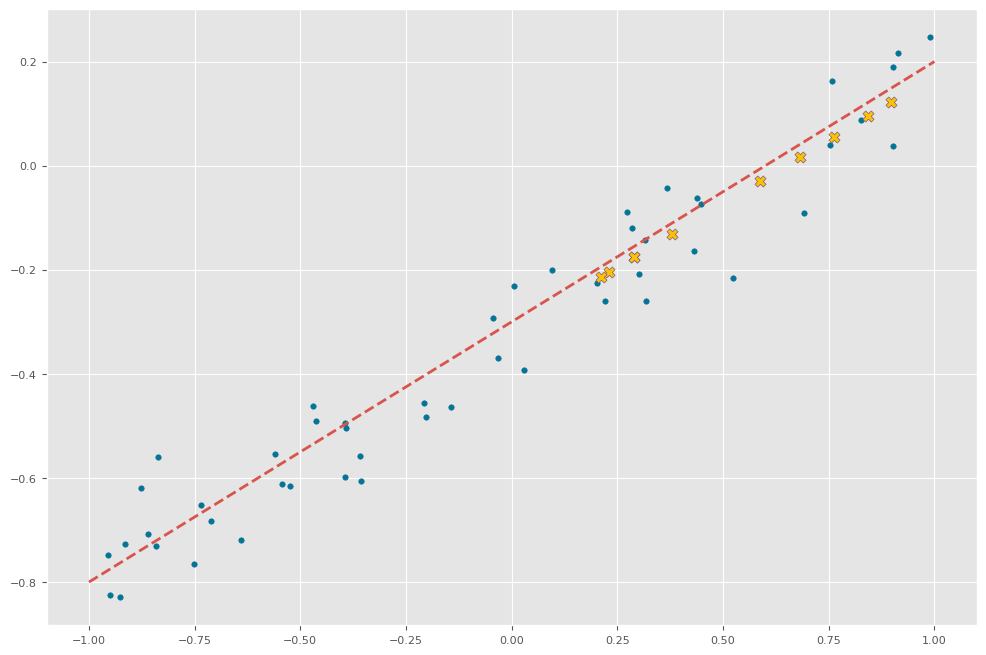

In [52]:
args = {}
plt.figure(figsize=(12,8))
plt.scatter(X, t1, s=15, color=colors[1])
plt.plot(x, y1, linewidth=2, color=colors[2], linestyle='dashed', label='Funzione reale')
plt.scatter(X_test, predict_equiv_kernel(X_test, X, t1, alpha, beta, args), color=colors[7], edgecolor=colors[5], marker='X')
plt.show()

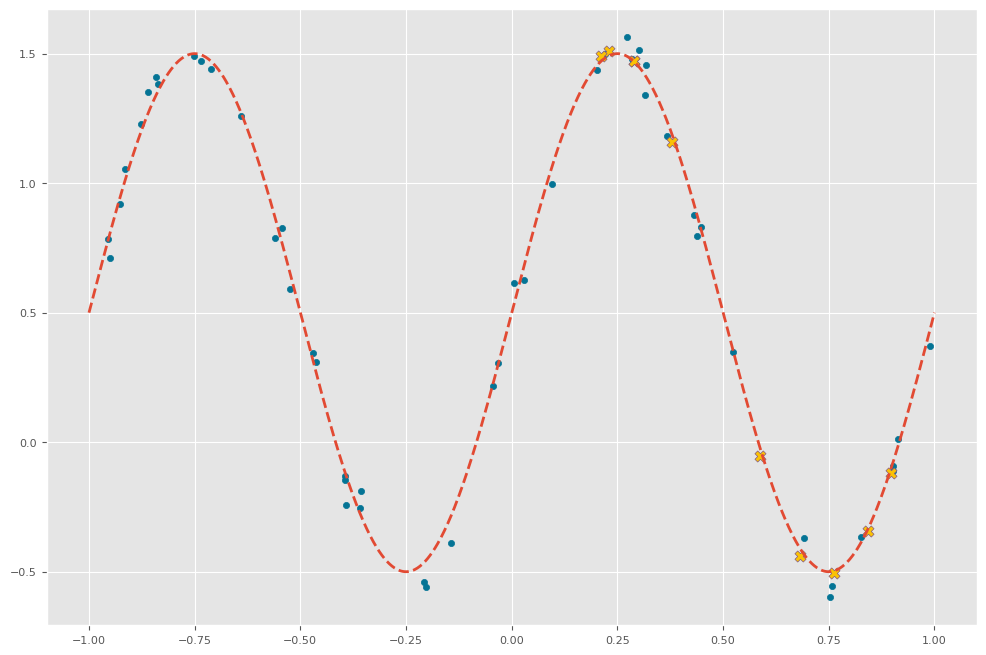

In [53]:
args = {}
plt.figure(figsize=(12,8))
plt.scatter(X, t2, s=20, color=colors[1])
plt.plot(x, y2, linewidth=2, linestyle='dashed')
plt.scatter(X_test, predict_equiv_kernel(X_test, X, t2, alpha, beta, args2), color=colors[7], edgecolor=colors[5], marker='X')
plt.show()

In the images below the value of the equivalent kernel is reported in color (reddish color - higher value) for all pairs in the domain $(-1,1)\times(-1,1)$ for different sets of base functions. It is possible to see that pairs with similar values (that is, points along the diagonal) tend to result into higher equivalent kernel values. As a consequence, when predicting $y(\mathbf{x})$ the target values of points in the training set at smaller distance from $\mathbf{x}$ receive higher weights: This corresponds to the application of a locality principle: nearby examples are more relevant for predictions.

In [239]:
n_values = 200
xx = np.linspace(-1, 1, n_values)
yy = np.linspace(-1, 1, n_values)
XX,YY = np.meshgrid(xx, yy)
func=np.vectorize(lambda x,y:equiv_kernel(x,y,X,t1,alpha,beta,args1))
Z=func(XX,YY)

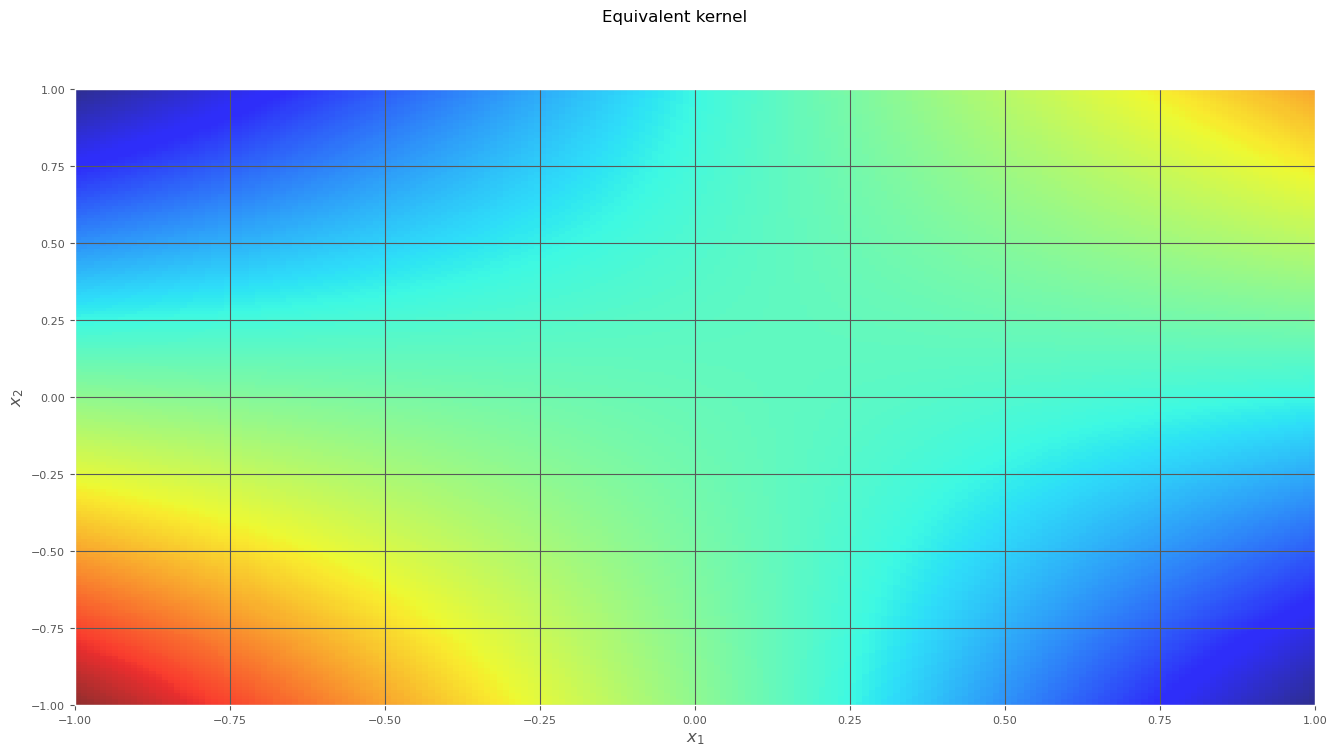

In [240]:
fig = plt.figure(figsize=(16,8))
ax=fig.gca()
imshow_handle = ax.imshow(Z, origin='lower', extent=(xx.min(),xx.max(), yy.min(), yy.max()), aspect='auto', alpha=.8)
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)
plt.xlim(-1,1)
plt.ylim(-1,1)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.grid(which='both', color='0.35')
plt.suptitle(u'Equivalent kernel')
plt.show()

In [241]:
n_values = 200
xx = np.linspace(-1, 1, n_values)
yy = np.linspace(-1, 1, n_values)
XX,YY = np.meshgrid(xx, yy)
func = np.vectorize(lambda x,y:equiv_kernel(x,y,X,t2,alpha,beta,args2))
Z = func(XX,YY)

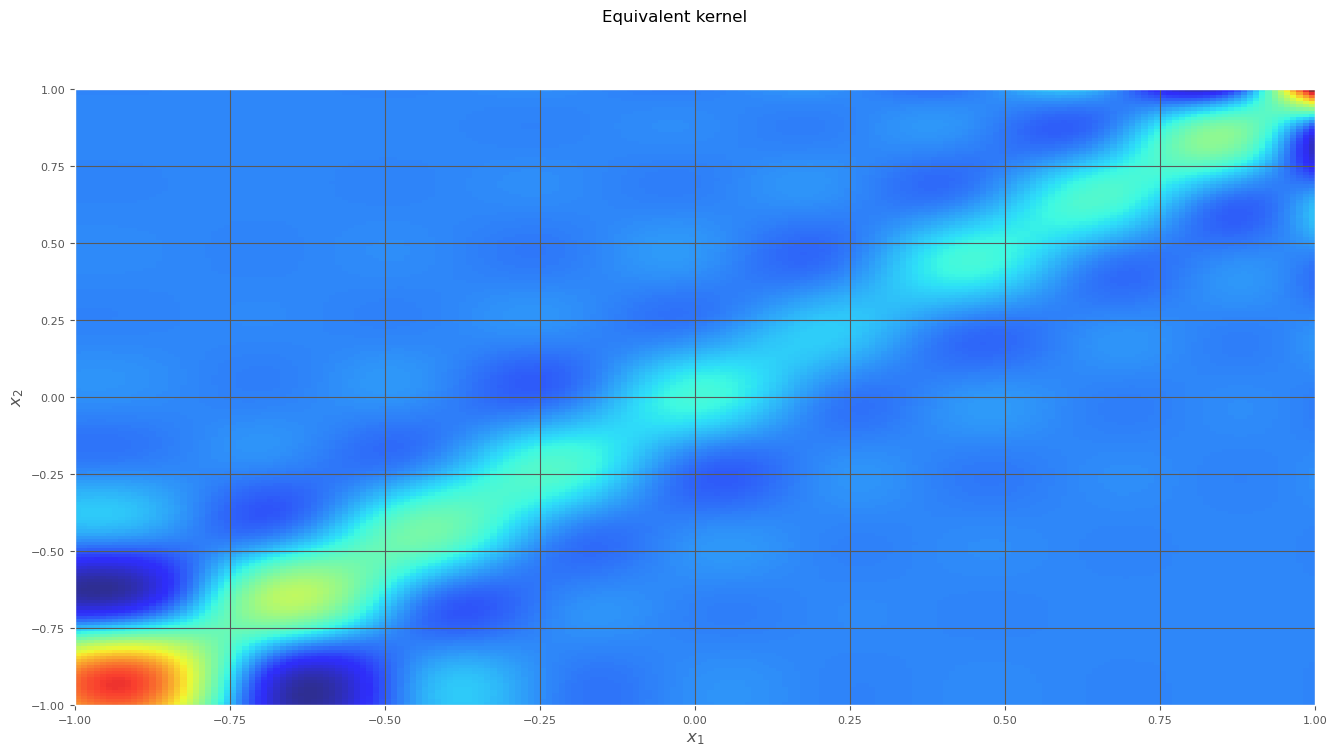

In [242]:
fig = plt.figure(figsize=(16,8))
ax=fig.gca()
imshow_handle = ax.imshow(Z, origin='lower', extent=(xx.min(),xx.max(), yy.min(), yy.max()), aspect='auto', alpha=.8)
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)
plt.xlim(-1,1)
plt.ylim(-1,1)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.grid(which='both', color='0.35')
plt.suptitle(u'Equivalent kernel')
plt.show()

Equivalent kernel is a case of *nonparametric* model, a model where the prediction is not performed by applying a suitable parametric function on the feature domain. Instead, the prediction is now derived as a weighted linear combination of the target values in $\mathbf{t}$. 

The weight associated to $t_i$ is defined in terms of a *similarity measure* between the corresponding item $\mathbf{x}_i$ and the item $\mathbf{x}$ whose target must be predicted.

The similarity is defined in terms of a *kernel* function $\kappa(\mathbf{x}_i,\mathbf{x})$

### Kernel regression

In kernel regression methods, the  target value corresponding to any item $\mathbf{x}$ is  predicted by referring to items in the training set, and in particular to the items which are closer to $\mathbf{x}$. This is controlled by referring to a *kernel* function $\kappa_h(\mathbf{x})$, which is non zero only in an interval around $0$.

$h$ is the *bandwidth* of the kernel, which controls the width of $\kappa_h(\mathbf{x})$

A possible, common kernel, is the gaussian (or RBF) kernel 
$$
g(\mathbf{x})=e^{-\frac{{\left\lVert\mathbf{x}\right\rVert}^2}{2h^2}}
$$

 In regression, we are interested in estimating the conditional expectation
$$
f(\mathbf{x})= E[{t|\mathbf{x}}]=\int tp(t|\mathbf{x})dt=\int t\frac{p(\mathbf{x},t)}{p(\mathbf{x})}dt=\frac{\int t\;p(\mathbf{x},t)dt}{p(\mathbf{x})}=\frac{\int t\;p(\mathbf{x},t)dt}{\int p(\mathbf{x},t)dt}
$$

By approximating the joint distribution through the kernel
$$
 p(\mathbf{x},t)\approx\frac{1}{n}\sum_{i=1}^n\kappa_h(\mathbf{x}-\mathbf{x}_i)\kappa_h(t-t_i)
$$
this results into
$$
 f(\mathbf{x})=\frac{\sum_{i=1}^n\kappa_h(\mathbf{x}-\mathbf{x}_i)t_i}{\sum_{i=1}^n\kappa_h(\mathbf{x}-\mathbf{x}_i)}
$$

By setting
$$
w_i(\mathbf{x})=\frac{\kappa_h(\mathbf{x}-\mathbf{x}_i)}{\sum_{j=1}^n\kappa_h(\mathbf{x}-\mathbf{x}_j)}
$$
we can write
$$
f(\mathbf{x})=\sum_{i=1}^nw_i(\mathbf{x})t_i
$$
that is, the predicted value is computed as a normalized linear combination of all target values, weighted by kernels.

In [54]:
def kernel(x, X, sigma):
    dist_mat = cdist(X, x, 'minkowski', p=2.)
    return np.exp((-0.5 / (sigma ** 2)) * (dist_mat ** 2))

In [55]:
def predict_kernel(x, X, t, h, args):
    weights = kernel(expand(x, **args), expand(X, **args), h)
    y = (weights*t).sum(axis=0)/weights.sum(axis=0)
    if np.isscalar(x):
        return y.item()
    else:
        return y

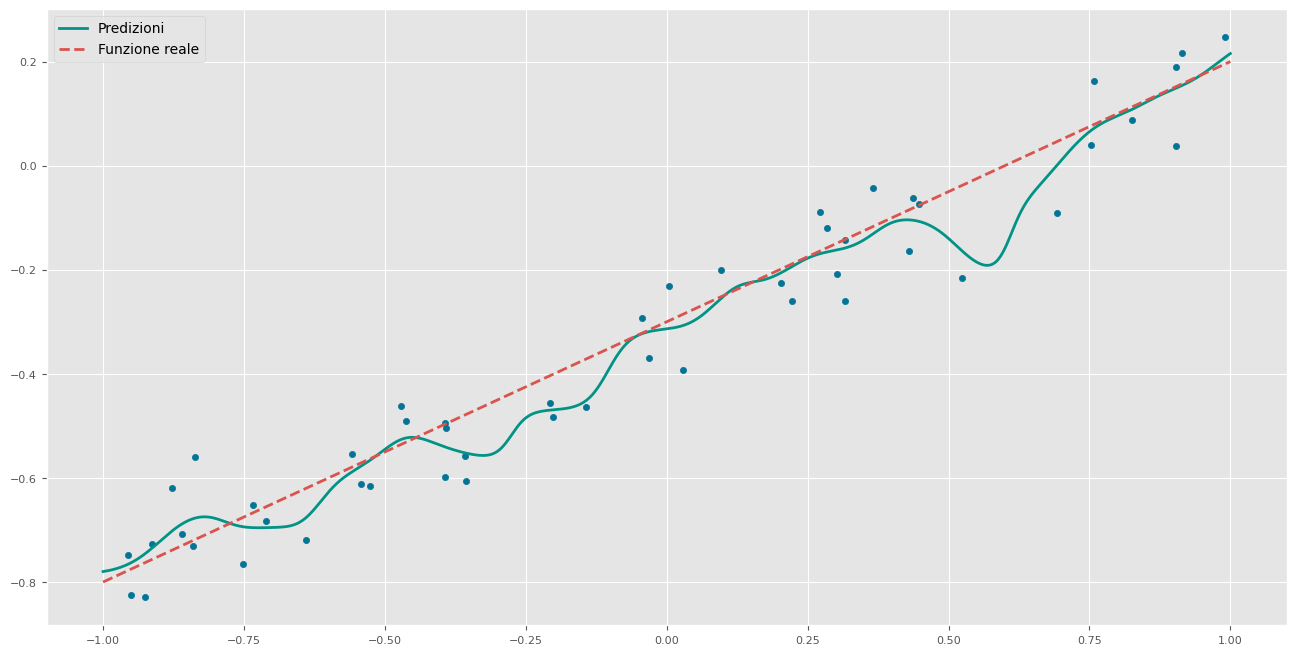

In [56]:
args = {}
h = .05
fig = plt.figure(figsize=(16,8))
plt.scatter(X, t1, s=20, color=colors[1])
plt.plot(x, predict_kernel(x,X, t1, h, args), linewidth=2, color=colors[6], label='Predizioni')
plt.plot(x, y1, linewidth=2, color=colors[2], linestyle='dashed', label='Funzione reale')
plt.legend()
plt.show()

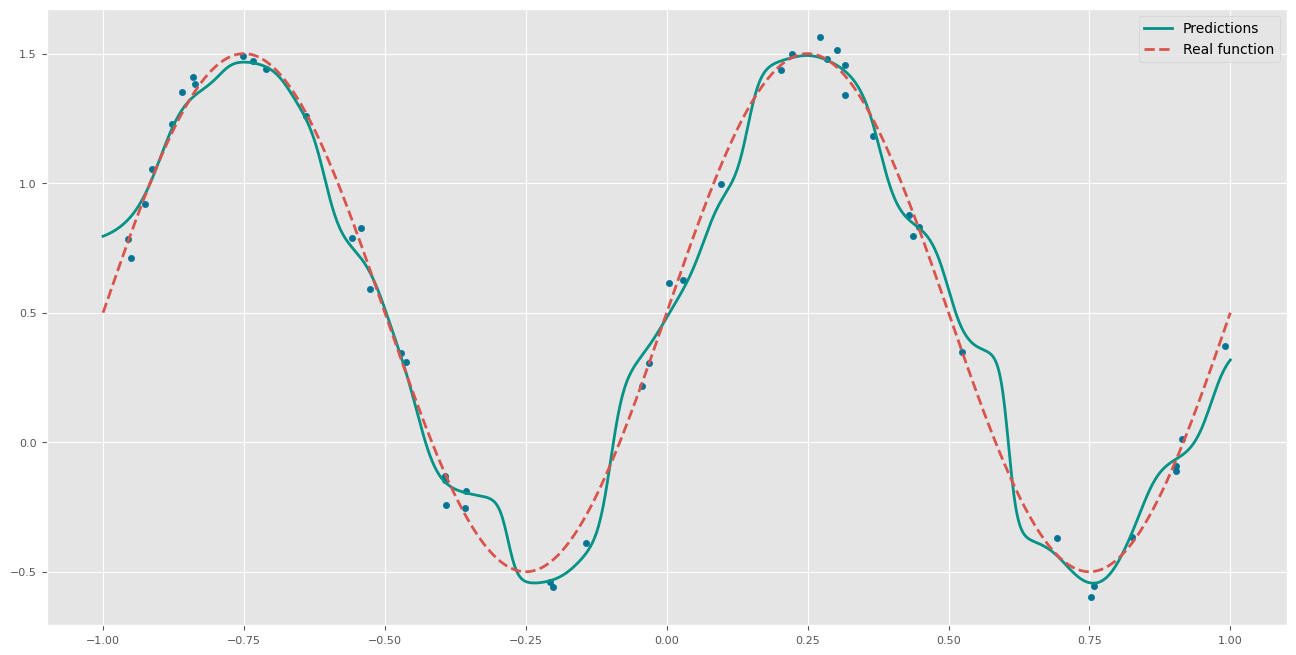

In [57]:
k = 10
mus = np.linspace(-1, 1, k)
args = {'bf': sigmoid_basis_function, 'bf_args_list':[{'mu':mu} for mu in mus]}
h = .1

fig = plt.figure(figsize=(16,8))
plt.scatter(X, t2, s=20, color=colors[1])
plt.plot(x, predict_kernel(x, X, t2, h, args), linewidth=2, color=colors[6], label='Predictions')
plt.plot(x, y2, linewidth=2, color=colors[2], linestyle='dashed', label='Real function')
plt.legend()
plt.show()

The best value for the bandwidth $h$ can be computed by selecting, in a given set of possible values, the one that result in the best predictions for a given set of items. Here, the items in the training set is considered.

In [58]:
def select_bandwidth(X, t, hs, args):
    mse = []
    for h in hs:
        XX = expand(X, **args)
        weights = kernel(XX, XX, h)
        weights = weights - np.diag(np.diag(weights))
        y = (weights*t).sum(axis=0)/weights.sum(axis=0)
        mse.append(((y[:, np.newaxis] - t) ** 2).mean())
    return hs[np.argmin(mse)]

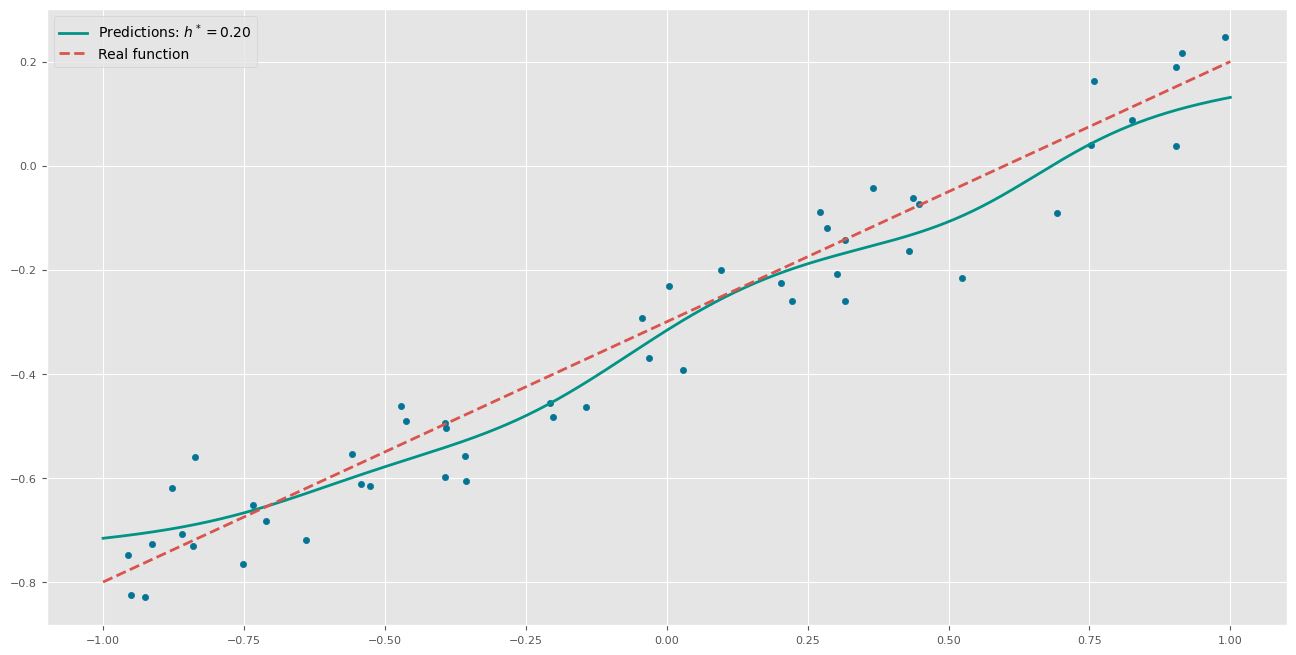

In [59]:
args = {}
hs=np.linspace(0.1, 1, 10)
h_star = select_bandwidth(X, t1, hs, args)
fig = plt.figure(figsize=(16,8))
plt.scatter(X, t1, s=20, color=colors[1])
plt.plot(x, predict_kernel(x,X, t1, h_star, args), linewidth=2, color=colors[6], label=f'Predictions: $h^*={h_star:3.2f}$')
plt.plot(x, y1, linewidth=2, color=colors[2], linestyle='dashed', label='Real function')
plt.legend()
plt.show()

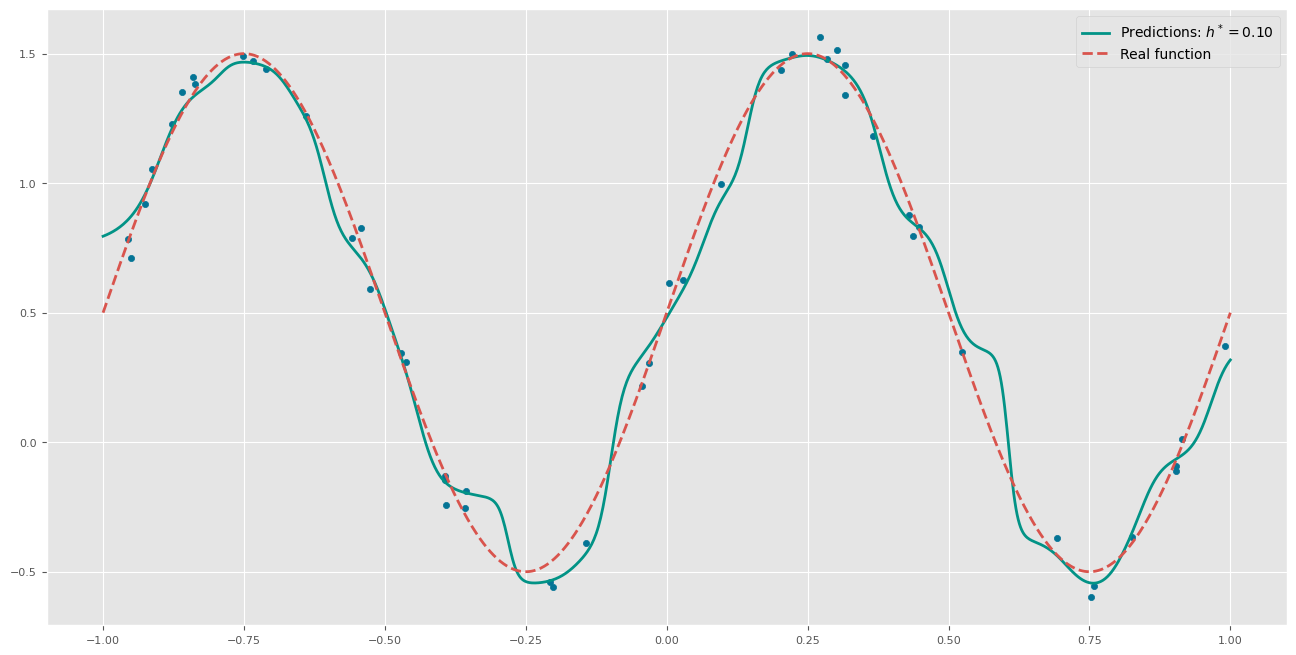

In [60]:
k = 10
mus = np.linspace(-1, 1, k)
args = {'bf': sigmoid_basis_function, 'bf_args_list':[{'mu':mu} for mu in mus]}

hs = np.linspace(0.1, 1, 10)
h_star = select_bandwidth(X, t2, hs, args)

fig = plt.figure(figsize=(16,8))
plt.scatter(X, t2, s=20, color=colors[1])
plt.plot(x, predict_kernel(x, X, t2, h_star, args), linewidth=2, color=colors[6], label=f'Predictions: $h^*={h_star:3.2f}$')
plt.plot(x, y2, linewidth=2, color=colors[2], linestyle='dashed', label='Real function')
plt.legend()
plt.show()

## Locally weighted regression

Locally weighted regression (LOESS) improves that approach by referring to a weighted version of the sum of squared differences loss function used in regression. 


If a value $t$ has to be predicted for an item $\mathbf{x}$, a _local_ version of the loss function is considered, 

$$
L(\mathbf{x})=\sum_{i=1}^n\kappa_i(\mathbf{x})(\mathbf{w}^T\overline{\mathbf{x}}_i-t_i)^2
$$

the weight $\kappa_i(\mathbf{x})$ is dependent from the _distance_ between $\mathbf{x}$ and $\mathbf{x}_i$, as defined by the kernel 
$$\kappa_i(\mathbf{x})=\kappa_h(\mathbf{x}-\mathbf{x}_i)$$

In [61]:
def kernel(x,xi,h):
    return np.exp(np.sum((xi - x) ** 2, axis=1) / (-2 * h * h))

The minimization of this loss function 
$$
\hat{\mathbf{w}}(\mathbf{x})=\argmin{\mathbf{w}}\sum_{i=1}^n\kappa_h(\mathbf{x}-\mathbf{x}_i)(\mathbf{w}^T\overline{\mathbf{x}}_i-t_i)^2
$$
has solution
$$
\hat{\mathbf{w}}(\mathbf{x}) = (\overline{\mathbf{X}}^T\Psi(\mathbf{x})\overline{\mathbf{X}})^{-1}\overline{\mathbf{X}}^T\Psi(\mathbf{x})\mathbf{t}
$$

where $\Psi(\mathbf{x})$ is a diagonal $n\times n$ matrix with $\Psi(\mathbf{x})_{ii}=\kappa_h(\mathbf{x}-\mathbf{x}_i)$


$$
\Psi(\mathbf{x}) = 
\begin{pmatrix}
\kappa_h(\mathbf{x}-\mathbf{x}_1) &  0 & \cdots & 0 \\ 
0 &  \kappa_h(\mathbf{x}-\mathbf{x}_2) & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 &  0 & \cdots & \kappa_h(\mathbf{x}-\mathbf{x}_n)
\end{pmatrix}
$$

In [252]:
def diag_kernel(x, X, h):
    return np.diag(kernel(X,x,h))

In [253]:
def local_regression_coeffs(x, X, t, h):
    psi = diag_kernel(x, X, h)
    X_ext = np.c_[np.ones(len(X)), X]
    return np.linalg.pinv((X_ext.T @ psi) @ X_ext) @ X_ext.T @ psi @ t


The prediction is then performed as usual, as
$$
y = \overline{\mathbf{x}}\hat{\mathbf{w}}(\mathbf{x})
$$

In [254]:
def local_regression(x, X, t, h):
    x_ext = np.r_[1, x]
    w = local_regression_coeffs(x, X, t, h)
    return x_ext @ w

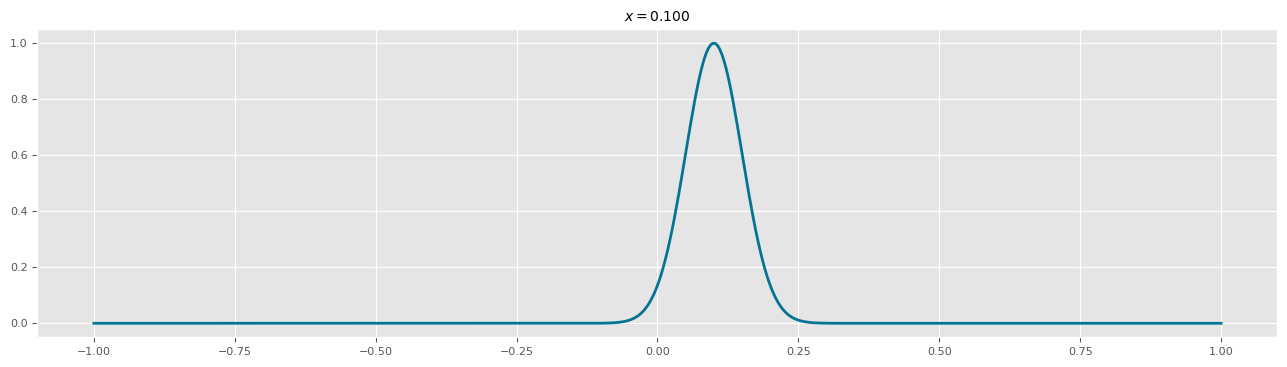

In [256]:
h = .05

x_ = 0.1

# calcola matrice kernel
psi = diag_kernel(np.array([x_]).reshape(-1,1),X,h)
domain = np.linspace(-1, 1, num=500)
f = plt.figure(figsize=(16,4))
plt.title('$x={0:5.3f}$'.format(x_))
plt.plot(domain, kernel(x_,domain.reshape(-1,1),h), c=colors[1])
plt.show()

In [257]:
y = local_regression(x_, X, t1, h)
w = local_regression_coeffs(x_, X, t1, h)

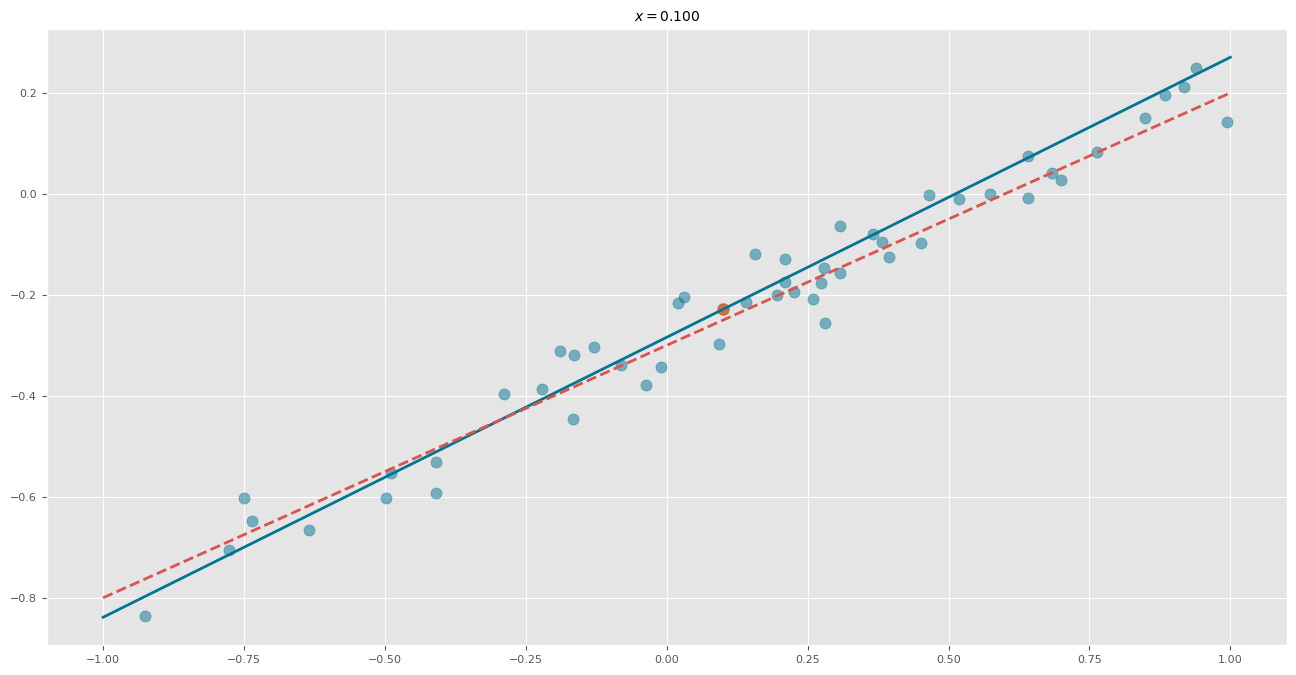

In [258]:
f = plt.figure(figsize=(16,8))
plt.title('$x={0:5.3f}$'.format(x_))
plt.scatter(X, t1, c= colors[1], alpha=.5)
plt.plot([x_], [y], marker='o', color=colors[4], alpha=.9)
plt.plot(domain, np.c_[np.ones(len(domain)), domain] @ w, color=colors[1])
plt.plot(x, y1, linewidth=2, color=colors[2], linestyle='dashed', label='Real function')
plt.show()

In [259]:
prediction = [local_regression(x, X, t1, h) for x in domain]

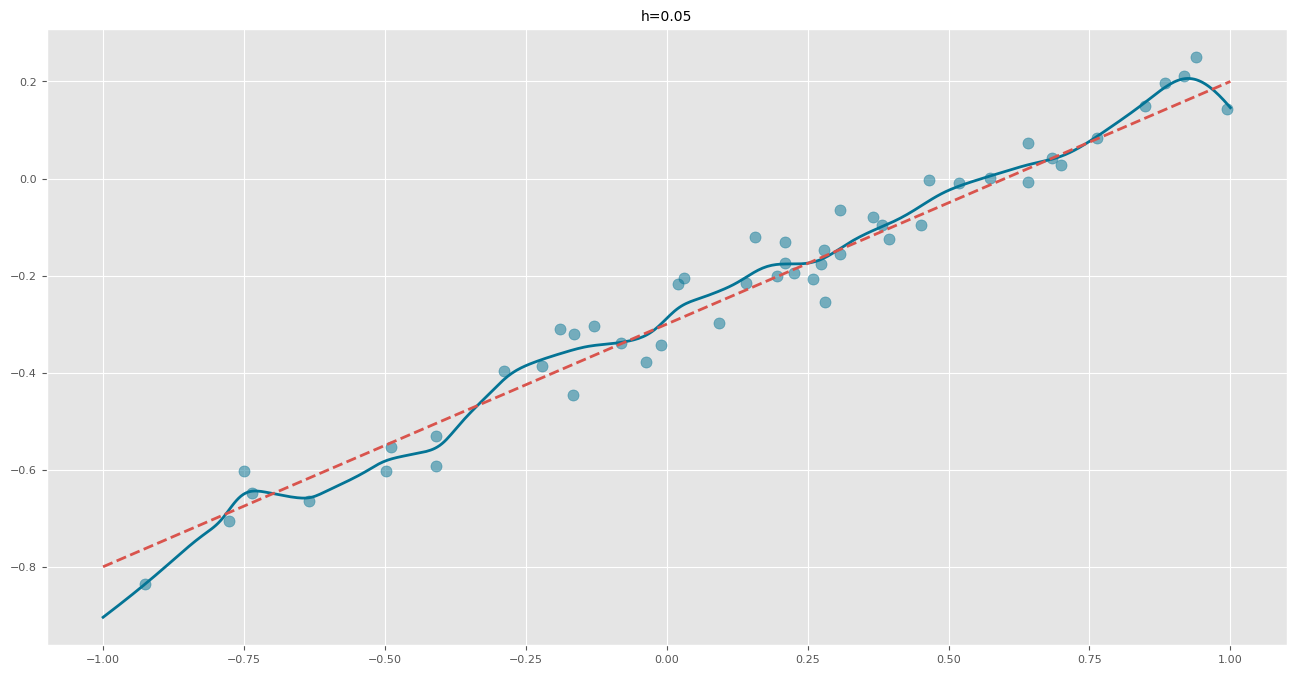

In [260]:
f = plt.figure(figsize=(16,8))
plt.title('h=%g' % h)
plt.scatter(X, t1, c= colors[1], alpha=.5)
plt.plot(domain, prediction, lw=2, c=colors[1])
plt.plot(x, y1, linewidth=2, color=colors[2], linestyle='dashed', label='Real function')
plt.show()

In [261]:
def select_bandwidth1(X, t, hs, args):
    XX = expand(X, **args)
    mse = []
    for h in hs:
        y = [local_regression(x, XX, t, h) for x in XX]
        mse.append(((y - t) ** 2).mean())
    return hs[np.argmin(mse)], np.min(mse)

In [262]:
hs = np.linspace(0.001, 0.002, 10)
h_star,mse=select_bandwidth1(X, t1, hs, args)

/var/folders/ny/mqy36hy55r3c22qq88f88lbm0000gn/T/ipykernel_71164/2341070764.py:7: RuntimeWarning: invalid value encountered in divide
  y = (weights*t).sum(axis=0)/weights.sum(axis=0)


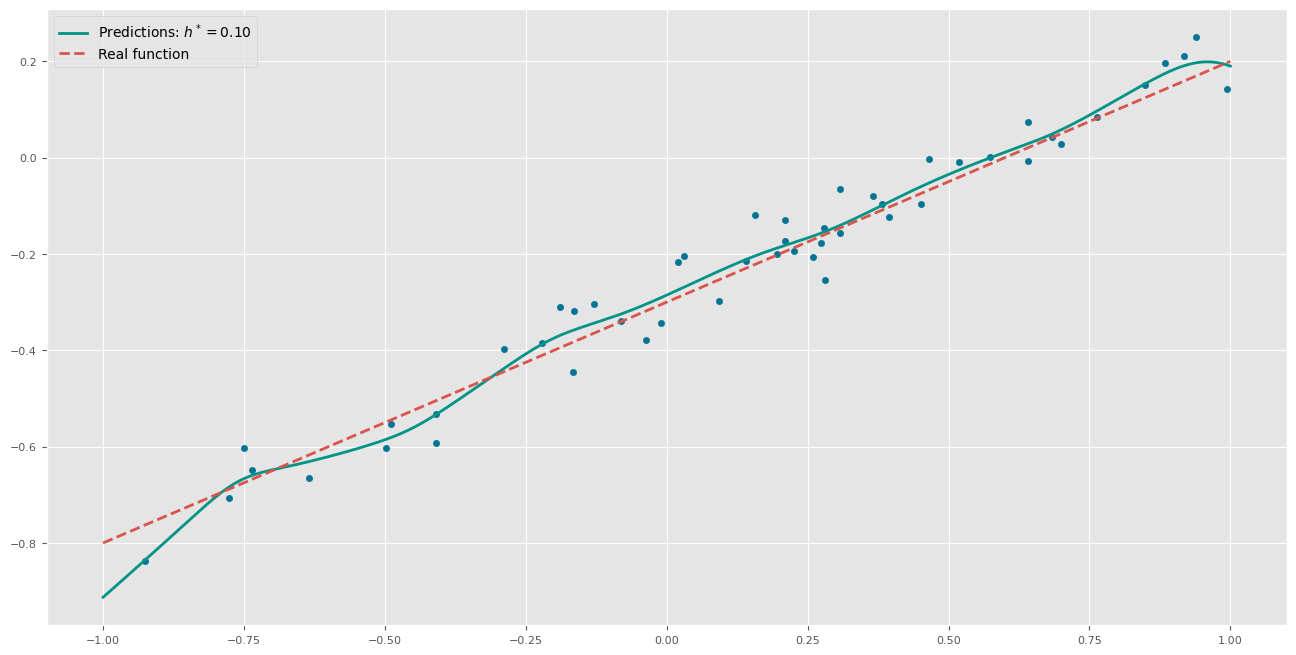

In [263]:
args = {}
hs=np.linspace(0.1, 1, 10)
h_star = select_bandwidth(X, t1, hs, args)
prediction_star = [local_regression(x, X, t1, h_star) for x in domain]
fig = plt.figure(figsize=(16,8))
plt.scatter(X, t1, s=20, color=colors[1])
plt.plot(domain, prediction_star, linewidth=2, color=colors[6], label=f'Predictions: $h^*={h_star:3.2f}$')
plt.plot(x, y1, linewidth=2, color=colors[2], linestyle='dashed', label='Real function')
plt.legend()
plt.show()